<p style="font-family: Times New Roman;font-size:35px;color:Maroon">Network-Analysis-Policy-Intervention</p>


In [63]:
# Then import all the required libraries
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from matplotlib import ticker
import networkx as nx

In [65]:
nodes = pd.read_csv("nodes_cluster_F.csv" , sep = ";")
nodes.head()

id  coord  core  gender
0  71645      0     1       0
1   8054      0     1       0
2   3723      0     0       0
3   8147      0     0       0
4   8141      0     1       1

In [67]:
edges = pd.read_csv("edges_cluster_F.csv" , sep = ";")
edges.head()

source  target  pre_link  post_link
0   71645    1885         0          1
1    8054    1948         1          1
2    3723    1948         1          1
3    8158    2962         0          1
4   92218    2962         0          1

In [69]:
# Identifier les liens bilat√©raux et cr√©er une colonne unique pour chaque lien
edges['link_id'] = edges.apply(lambda row: tuple(sorted([row['source'], row['target']])), axis=1)

# Compter les occurrences de chaque lien
link_counts = edges['link_id'].value_counts()
print(f"Nombre de liens uniques: {link_counts.size}")
print(f"Nombre de liens bilat√©raux (apparaissant 2 fois): {sum(link_counts == 2)}")

# Filtrer pour ne garder qu'une version unique de chaque lien
edges_unique = edges.drop_duplicates(subset=['link_id']).drop(columns=['link_id'])
print(f"Nombre de lignes apr√®s suppression des doublons: {len(edges_unique)}")

# Cr√©er une version canonique des liens (source < target)
edges_canonical = edges.assign(
    source=edges['link_id'].apply(lambda x: x[0]),
    target=edges['link_id'].apply(lambda x: x[1])
).drop_duplicates(subset=['source', 'target']).drop(columns=['link_id'])
print(f"Nombre de lignes dans la version canonique: {len(edges_canonical)}")

# V√©rifier les liens unidirectionnels
single_links = link_counts[link_counts == 1]
if not single_links.empty:
    print(f"\nAttention: {len(single_links)} liens n'apparaissent qu'une seule fois!")
    print("Exemples de ces liens unidirectionnels:")
    print(edges[edges['link_id'].isin(single_links.index)].head())


Nombre de liens uniques: 1606
Nombre de liens bilat√©raux (apparaissant 2 fois): 1606
Nombre de lignes apr√®s suppression des doublons: 1606
Nombre de lignes dans la version canonique: 1606


### 1) Analyse de la structure du r√©seau

In [72]:
# Cr√©ation du r√©seau pr√©-traitement
G_pre = nx.Graph()
G_pre.add_nodes_from(nodes['id'])
pre_edges = edges_unique[edges_unique['pre_link'] == 1]
G_pre.add_edges_from([(row['source'], row['target']) for _, row in pre_edges.iterrows()])

# Cr√©ation du r√©seau post-traitement
G_post = nx.Graph()
G_post.add_nodes_from(nodes['id'])
post_edges = edges_unique[edges_unique['post_link'] == 1]
G_post.add_edges_from([(row['source'], row['target']) for _, row in post_edges.iterrows()])

# Ajout des attributs aux n≈ìuds
for _, row in nodes.iterrows():
    node_id = row['id']
    if node_id in G_pre.nodes():
        G_pre.nodes[node_id]['gender'] = row['gender']
        G_pre.nodes[node_id]['core'] = row['core']
        G_pre.nodes[node_id]['coord'] = row['coord']
    if node_id in G_post.nodes():
        G_post.nodes[node_id]['gender'] = row['gender']
        G_post.nodes[node_id]['core'] = row['core']
        G_post.nodes[node_id]['coord'] = row['coord']

# V√©rification des r√©seaux cr√©√©s
print("\nR√©seau pr√©-traitement:")
print(f"Nombre de n≈ìuds: {G_pre.number_of_nodes()}")
print(f"Nombre de liens: {G_pre.number_of_edges()}")

print("\nR√©seau post-traitement:")
print(f"Nombre de n≈ìuds: {G_post.number_of_nodes()}")
print(f"Nombre de liens: {G_post.number_of_edges()}")


R√©seau pr√©-traitement:
Nombre de n≈ìuds: 310
Nombre de liens: 869

R√©seau post-traitement:
Nombre de n≈ìuds: 310
Nombre de liens: 1258


In [74]:
# V√©rification concise des attributs des deux premiers n≈ìuds
first_two_ids = list(nodes['id'])[:2]

print("Dans le dataframe nodes:")
print(nodes[nodes['id'].isin(first_two_ids)])

print("\nDans les r√©seaux:")
for period, G in [("Pr√©", G_pre), ("Post", G_post)]:
    print(f"\n{period}-traitement:")
    for node_id in first_two_ids:
        if node_id in G.nodes():
            attrs = G.nodes[node_id]
            print(f"N≈ìud {node_id}: gender={attrs.get('gender')}, core={attrs.get('core')}, "
                  f"coord={attrs.get('coord')}, degr√©={G.degree(node_id)}")

Dans le dataframe nodes:
      id  coord  core  gender
0  71645      0     1       0
1   8054      0     1       0

Dans les r√©seaux:

Pr√©-traitement:
N≈ìud 71645: gender=0, core=1, coord=0, degr√©=2
N≈ìud 8054: gender=0, core=1, coord=0, degr√©=4

Post-traitement:
N≈ìud 71645: gender=0, core=1, coord=0, degr√©=4
N≈ìud 8054: gender=0, core=1, coord=0, degr√©=6


### Objectif n¬∞1

In [77]:
def calculate_network_metrics(G, name):
    n_nodes = G.number_of_nodes()
    n_edges = G.number_of_edges()
    
    # Pr√©paration pour le calcul du chemin moyen
    largest_cc = max(nx.connected_components(G), key=len)
    largest_G = G.subgraph(largest_cc).copy()
    
    # Toutes les m√©triques en une seule fois
    metrics = {
        'R√©seau': name,
        'Nombre de n≈ìuds (ordre)': n_nodes,
        'Nombre de liens (taille)': n_edges,
        'Degr√© moyen du r√©seau': round(2 * n_edges / n_nodes, 3),
        'Densit√© du r√©seau': round(nx.density(G), 4),
        'Average local clustering coefficient': round(nx.average_clustering(G), 4),
        'Global clustering coefficient': round(nx.transitivity(G), 4),
        'Average shortest path (plus grande composante)': round(nx.average_shortest_path_length(largest_G), 4),
        '% n≈ìuds dans plus grande composante': round(len(largest_cc) / n_nodes * 100, 2)
    }
    
    return metrics

# Calcul et affichage des m√©triques
metrics_df = pd.DataFrame([
    calculate_network_metrics(G_pre, "Valeurs avant la politique"),
    calculate_network_metrics(G_post, "Valeurs apr√®s la politique")
]).set_index('R√©seau')

print("\nStatistiques calcul√©es sur le r√©seau avant et apr√®s la mise en place de la politique:")
print(metrics_df)


Statistiques calcul√©es sur le r√©seau avant et apr√®s la mise en place de la politique:
                            Nombre de n≈ìuds (ordre)  Nombre de liens (taille)  \
R√©seau                                                                          
Valeurs avant la politique                      310                       869   
Valeurs apr√®s la politique                      310                      1258   

                            Degr√© moyen du r√©seau  Densit√© du r√©seau  \
R√©seau                                                                 
Valeurs avant la politique                  5.606             0.0181   
Valeurs apr√®s la politique                  8.116             0.0263   

                            Average local clustering coefficient  \
R√©seau                                                             
Valeurs avant la politique                                 0.446   
Valeurs apr√®s la politique                                 0.563   

            

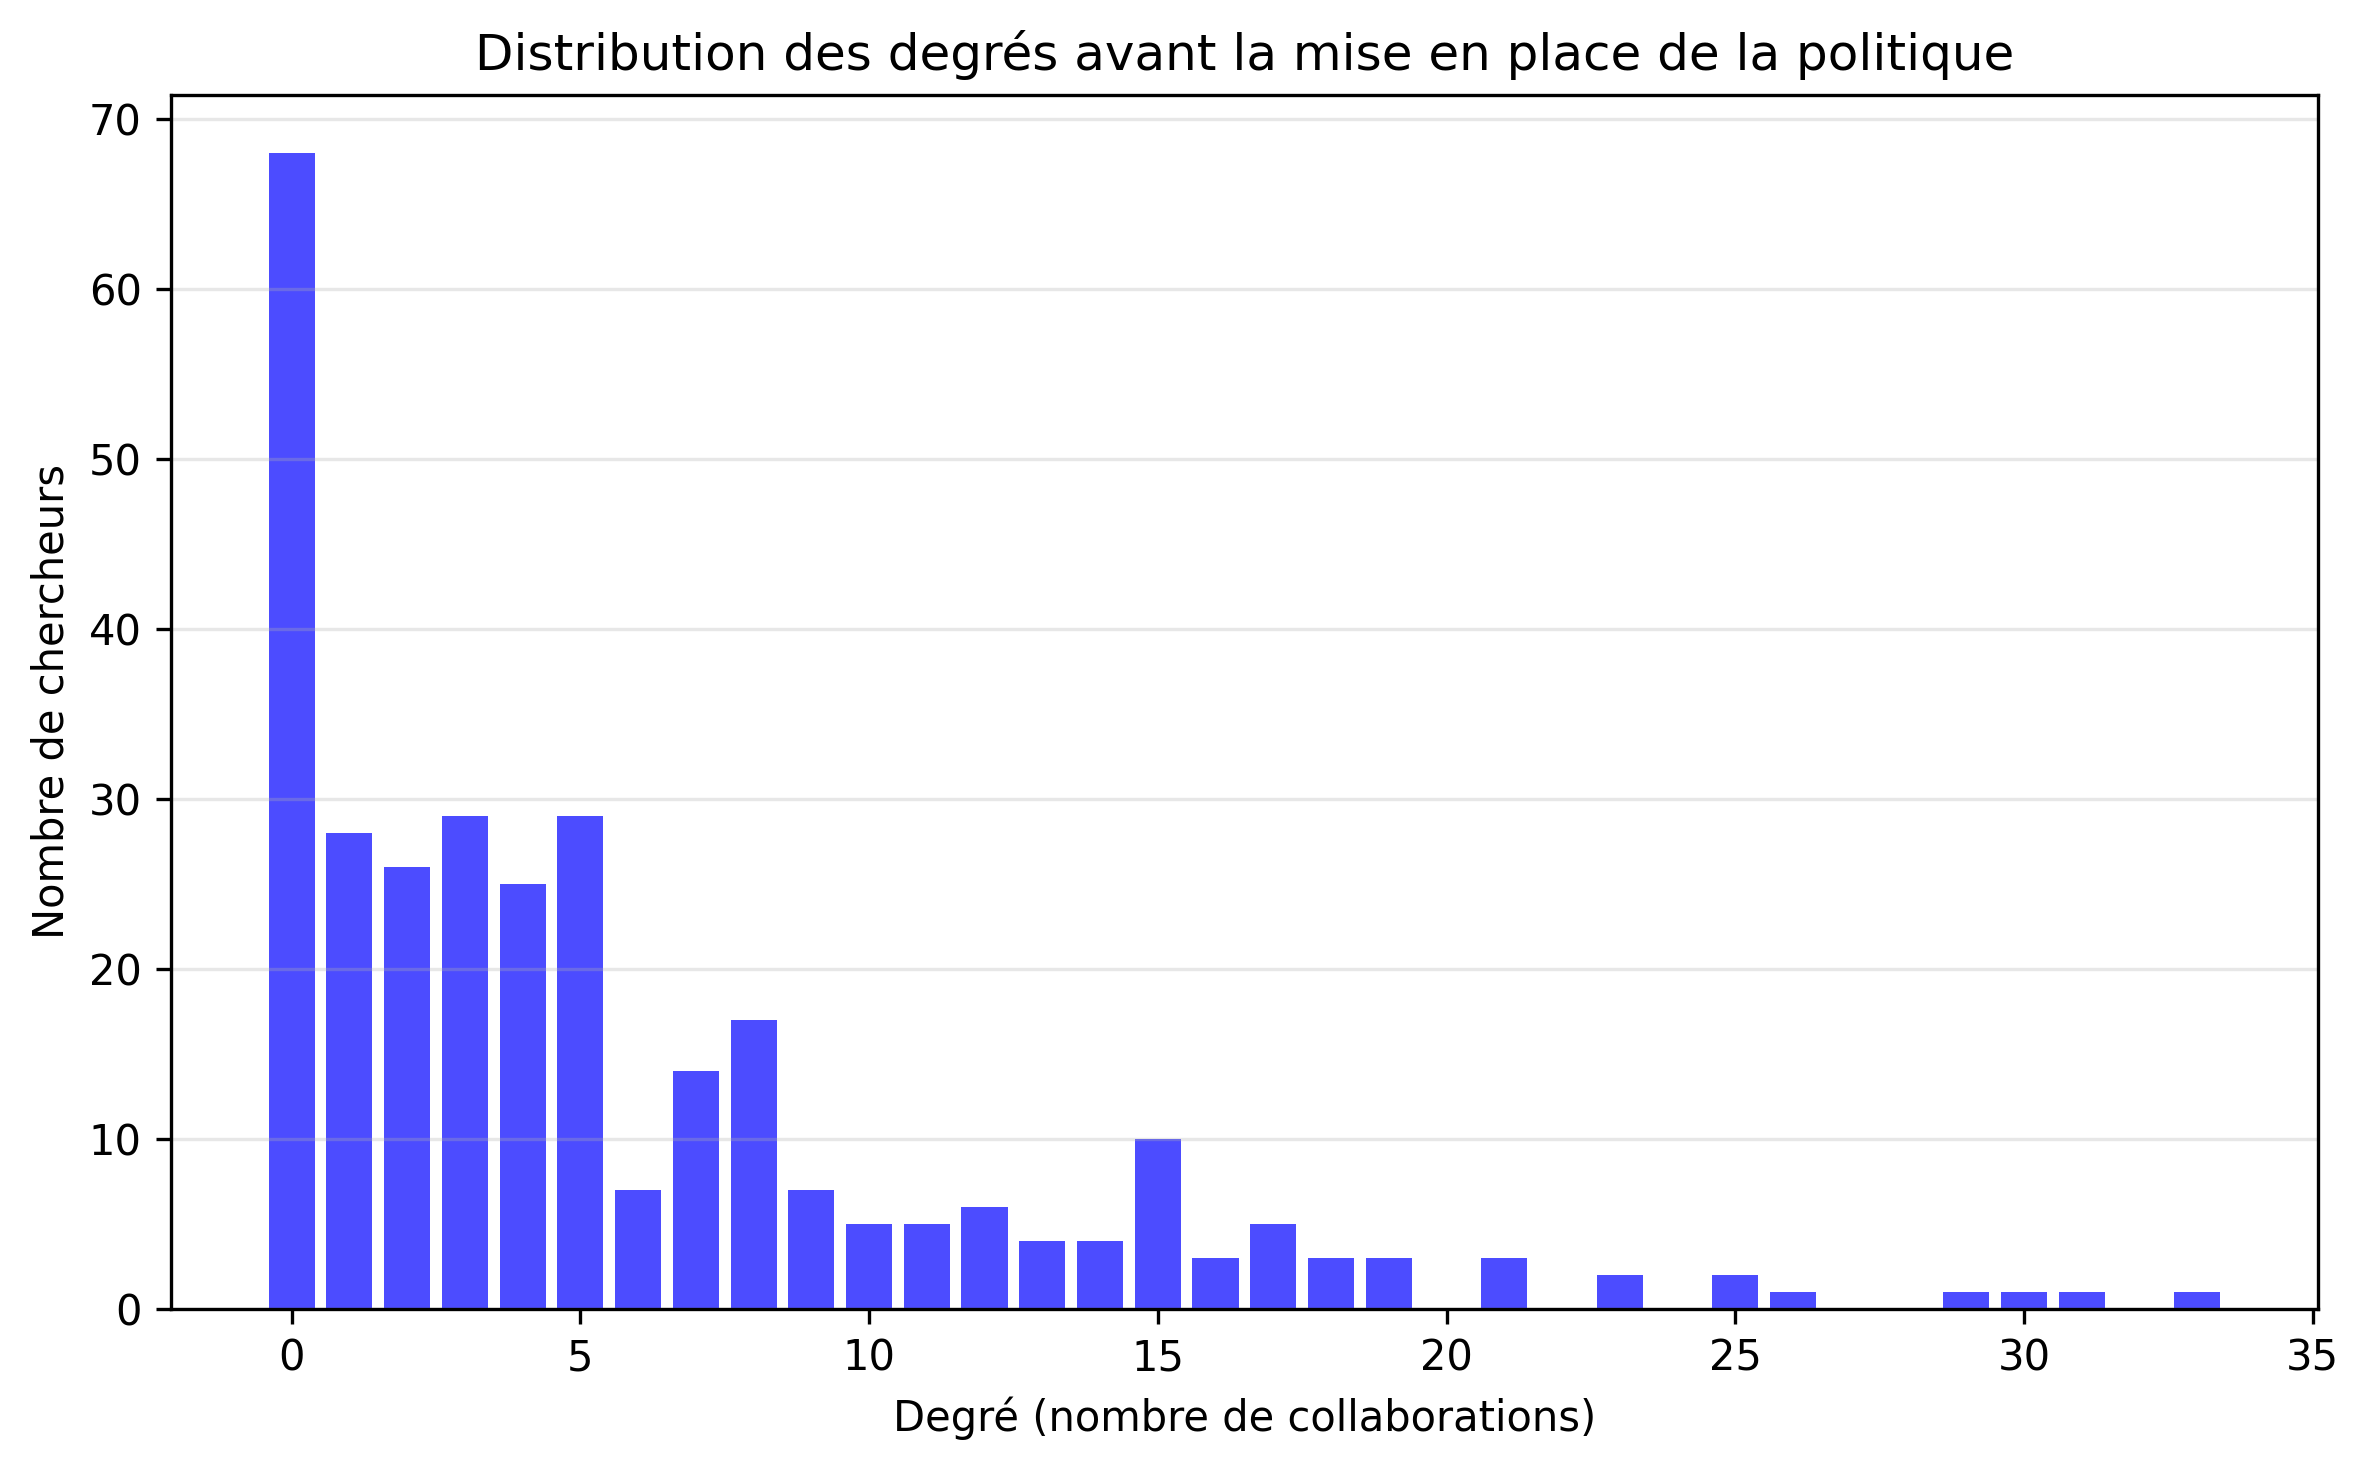

In [79]:
# Distribution des degr√©s avant la mise en place de la politique
pre_degrees = [d for _, d in G_pre.degree()]
degree_counts = np.unique(pre_degrees, return_counts=True)

# Cr√©ation du graphique
fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
ax.bar(degree_counts[0], degree_counts[1], color='blue', alpha=0.7)
ax.set_xlabel('Degr√© (nombre de collaborations)')
ax.set_ylabel('Nombre de chercheurs')
ax.set_title('Distribution des degr√©s avant la mise en place de la politique')
ax.xaxis.set_major_locator(ticker.MultipleLocator(5))
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distribution_pre.png', dpi=300)
plt.show()

Interpr√©tation de la distribution des degr√©s avant la mise en place de la politique :
Observation g√©n√©rale :

La majorit√© des n≈ìuds (chercheurs) ont un degr√© faible, c'est-√†-dire qu'ils ont peu de collaborations. Par exemple, on observe un pic important autour de 0 √† 2 collaborations.
Tr√®s peu de n≈ìuds ont un degr√© √©lev√© (au-del√† de 15 collaborations), ce qui indique que les collaborations sont concentr√©es autour de quelques individus tr√®s connect√©s.
Structure du r√©seau avant la politique :

Le r√©seau semble √™tre h√©t√©rog√®ne, avec une majorit√© de chercheurs faiblement connect√©s et une minorit√© de chercheurs jouant un r√¥le central (avec un degr√© √©lev√©).
Cela peut indiquer une structure en "√©toile" ou en "hub-and-spoke", o√π quelques individus tr√®s connect√©s agissent comme des points centraux reliant plusieurs autres.
Implications pour la politique :

Avant la mise en place de la politique, le r√©seau montre une certaine fragmentation, avec de nombreux chercheurs ayant peu ou pas de collaborations.
La politique pourrait viser √† r√©duire cette fragmentation en augmentant les connexions des chercheurs faiblement connect√©s, ce qui rendrait le r√©seau plus inclusif et √©quilibr√©.
Lien avec votre projet :

Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, cette distribution initiale sert de point de r√©f√©rence. Vous pourrez comparer cette distribution avec celle apr√®s la politique pour voir si les chercheurs faiblement connect√©s ont b√©n√©fici√© d'une augmentation de leurs collaborations.

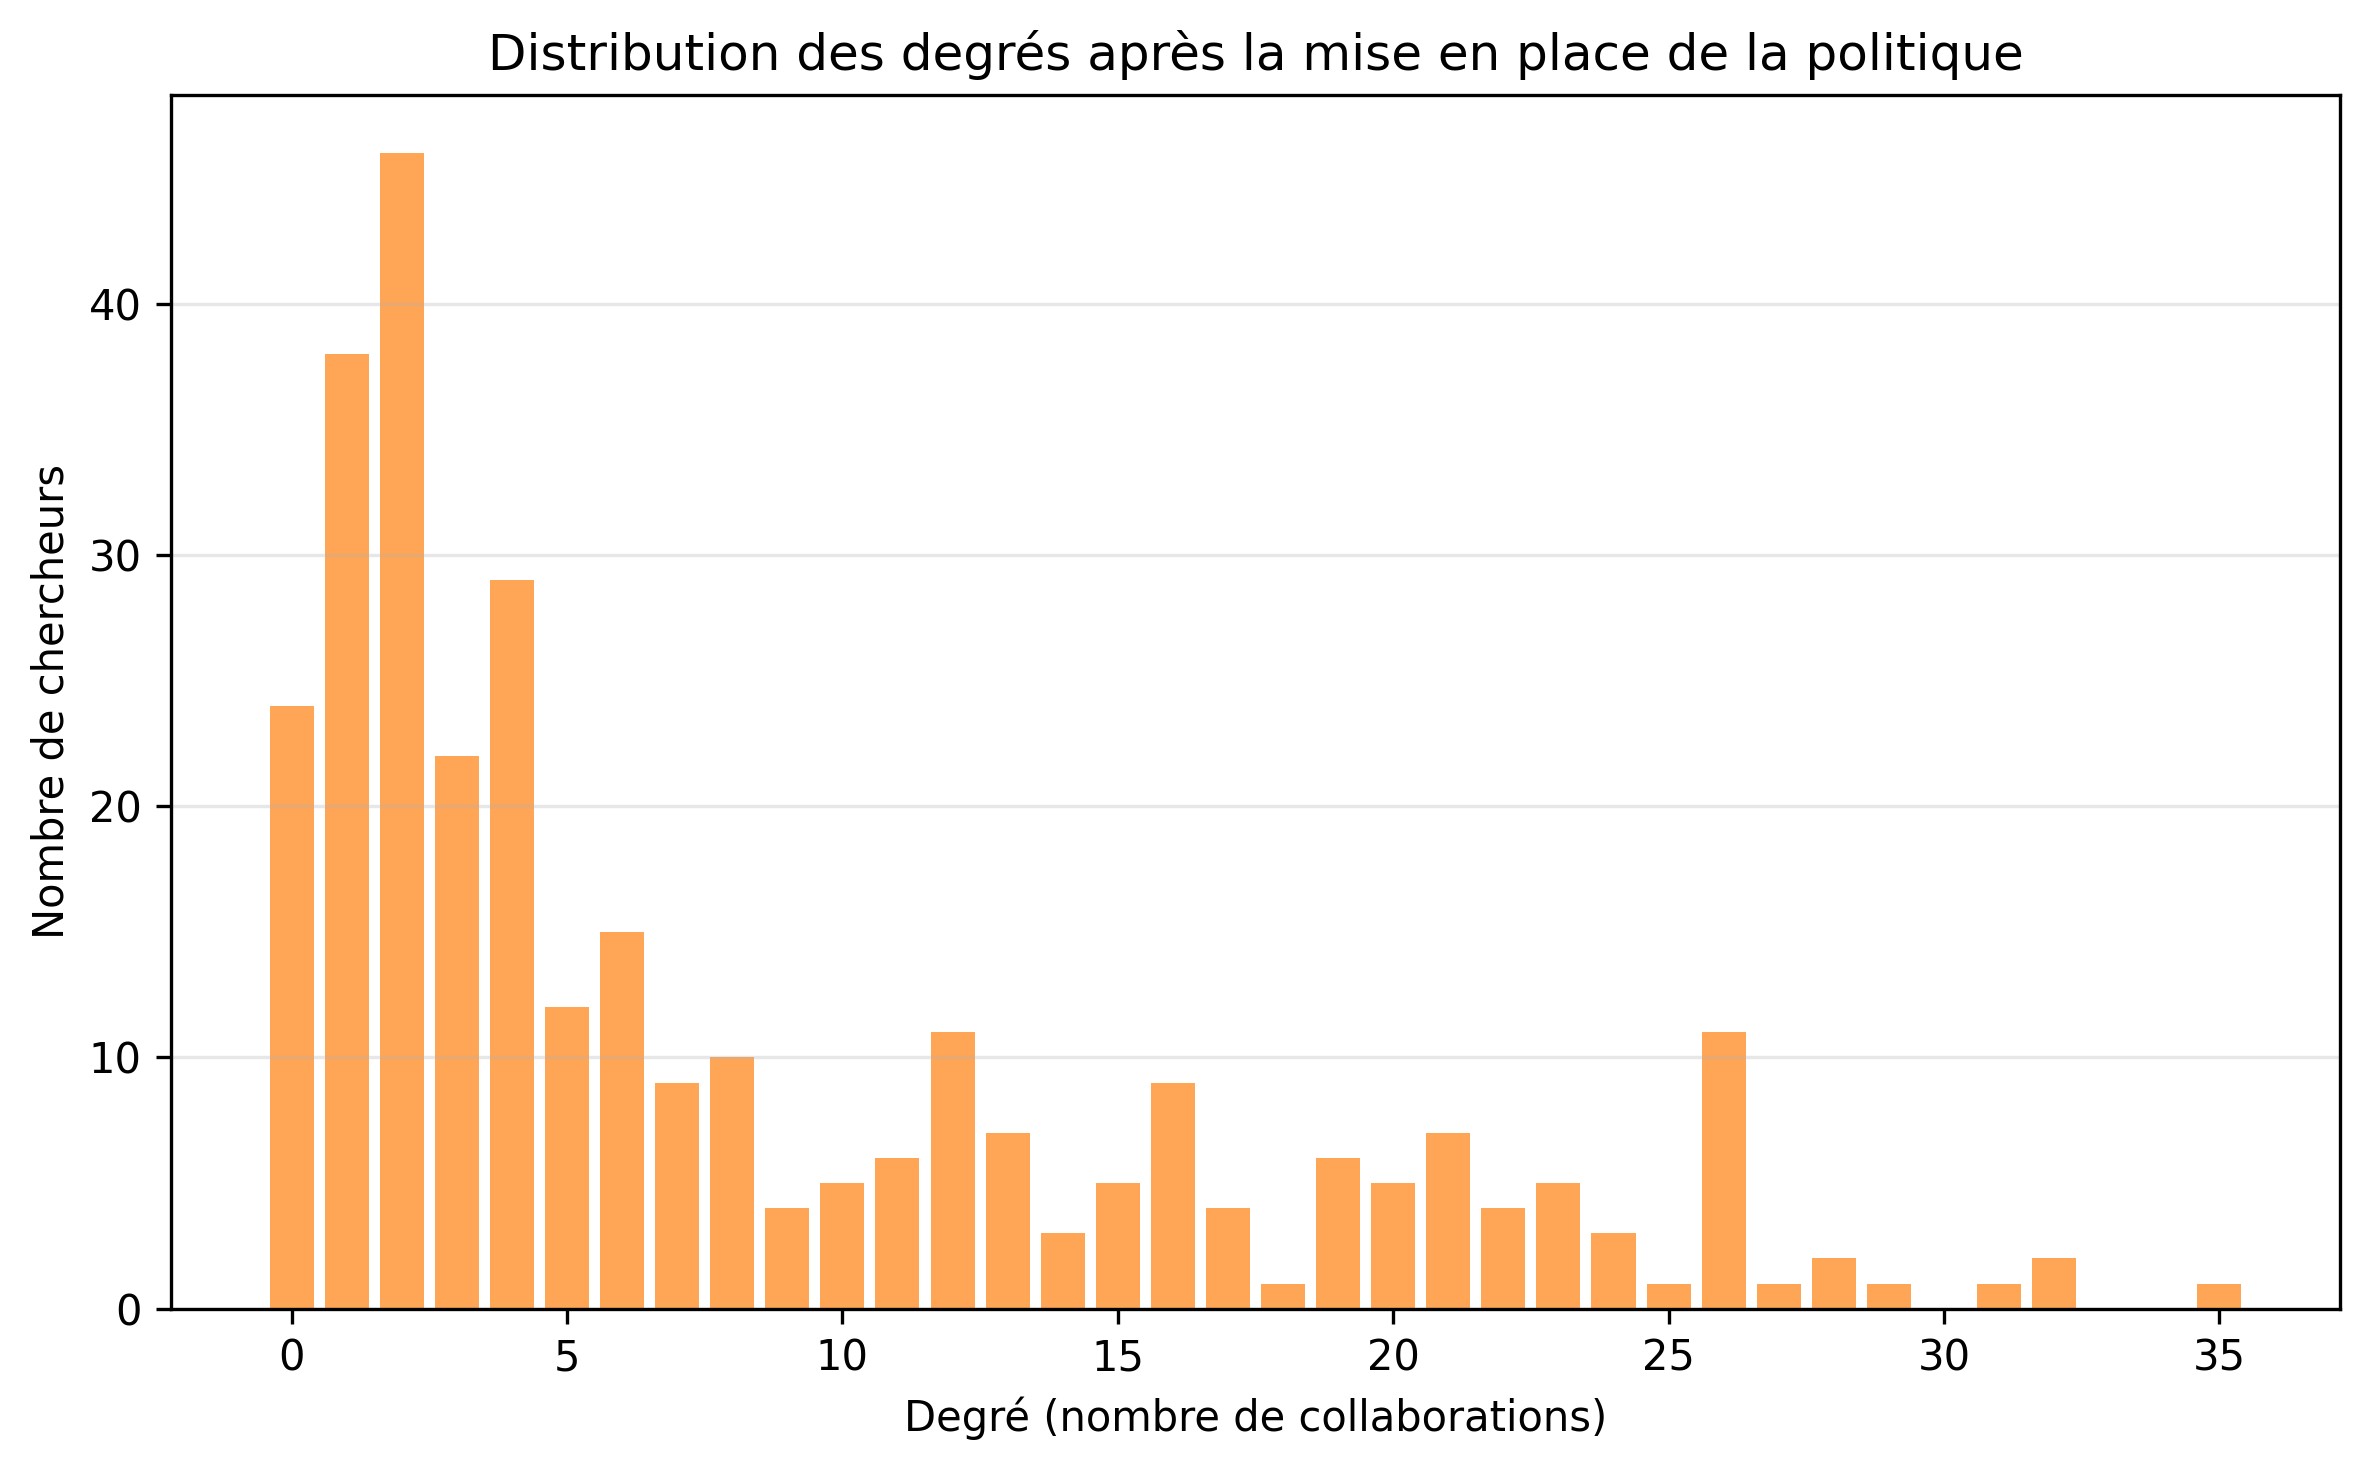

In [81]:
# Distribution des degr√©s apr√®s la mise en place de la politique
post_degrees = [d for _, d in G_post.degree()]
degree_counts = np.unique(post_degrees, return_counts=True)

# Cr√©ation du graphique
plt.figure(figsize=(8, 5), dpi=300)
plt.bar(degree_counts[0], degree_counts[1], color='tab:orange', alpha=0.7)
plt.xlabel('Degr√© (nombre de collaborations)')
plt.ylabel('Nombre de chercheurs')
plt.title('Distribution des degr√©s apr√®s la mise en place de la politique')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('degree_distribution_post.png', dpi=300)
plt.show()

### **Interpr√©tation de la distribution des degr√©s apr√®s la mise en place de la politique :**

1. **Observation g√©n√©rale :**
   - La majorit√© des chercheurs ont un faible degr√© (entre 0 et 5 collaborations), ce qui est coh√©rent avec la structure typique des r√©seaux sociaux o√π la plupart des individus ont peu de connexions.
   - Cependant, on observe une r√©partition plus √©tendue des degr√©s, avec des chercheurs ayant jusqu'√† **30 ou 35 collaborations**, ce qui indique l'existence de n≈ìuds tr√®s connect√©s (hubs).

2. **Structure du r√©seau :**
   - La pr√©sence de chercheurs avec un degr√© √©lev√© (au-del√† de 20 collaborations) montre que certains individus jouent un r√¥le central dans le r√©seau, en connectant de nombreux autres chercheurs.
   - Par rapport √† la p√©riode pr√©-politique, cette distribution semble indiquer une augmentation des connexions pour plusieurs chercheurs, en particulier ceux qui √©taient d√©j√† bien connect√©s.

3. **Impact de la politique :**
   - La politique semble avoir favoris√© une augmentation des collaborations, non seulement pour les chercheurs faiblement connect√©s, mais aussi pour ceux qui √©taient d√©j√† bien int√©gr√©s dans le r√©seau.
   - Cela peut indiquer que la politique a renforc√© les hubs existants tout en int√©grant davantage de chercheurs faiblement connect√©s.

4. **Comparaison avec la p√©riode pr√©-politique :**
   - Par rapport √† la distribution avant la politique, on peut supposer que :
     - Les chercheurs faiblement connect√©s (degr√© 0 √† 2) ont vu leur degr√© augmenter, ce qui r√©duit la fragmentation du r√©seau.
     - Les chercheurs d√©j√† bien connect√©s (degr√© √©lev√©) ont renforc√© leur position, jouant un r√¥le encore plus central dans le r√©seau.

5. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, cette distribution post-politique montre que la politique a eu un effet structurant sur le r√©seau, en augmentant les connexions globales et en int√©grant davantage de chercheurs.
   - Vous pourriez approfondir cette analyse pour d√©terminer si cet effet est √©quitable entre les groupes (par exemple, hommes/femmes, core/non-core).

---

### **Conclusion :**
La politique semble avoir eu un effet structurant sur le r√©seau, en augmentant les connexions globales et en renfor√ßant les collaborations. Cela peut √™tre interpr√©t√© comme une am√©lioration de la coh√©sion et de l'inclusivit√© du r√©seau. Pour aller plus loin, il serait int√©ressant d'examiner si ces changements b√©n√©ficient √©quitablement √† tous les groupes ou s'ils renforcent les in√©galit√©s existantes.

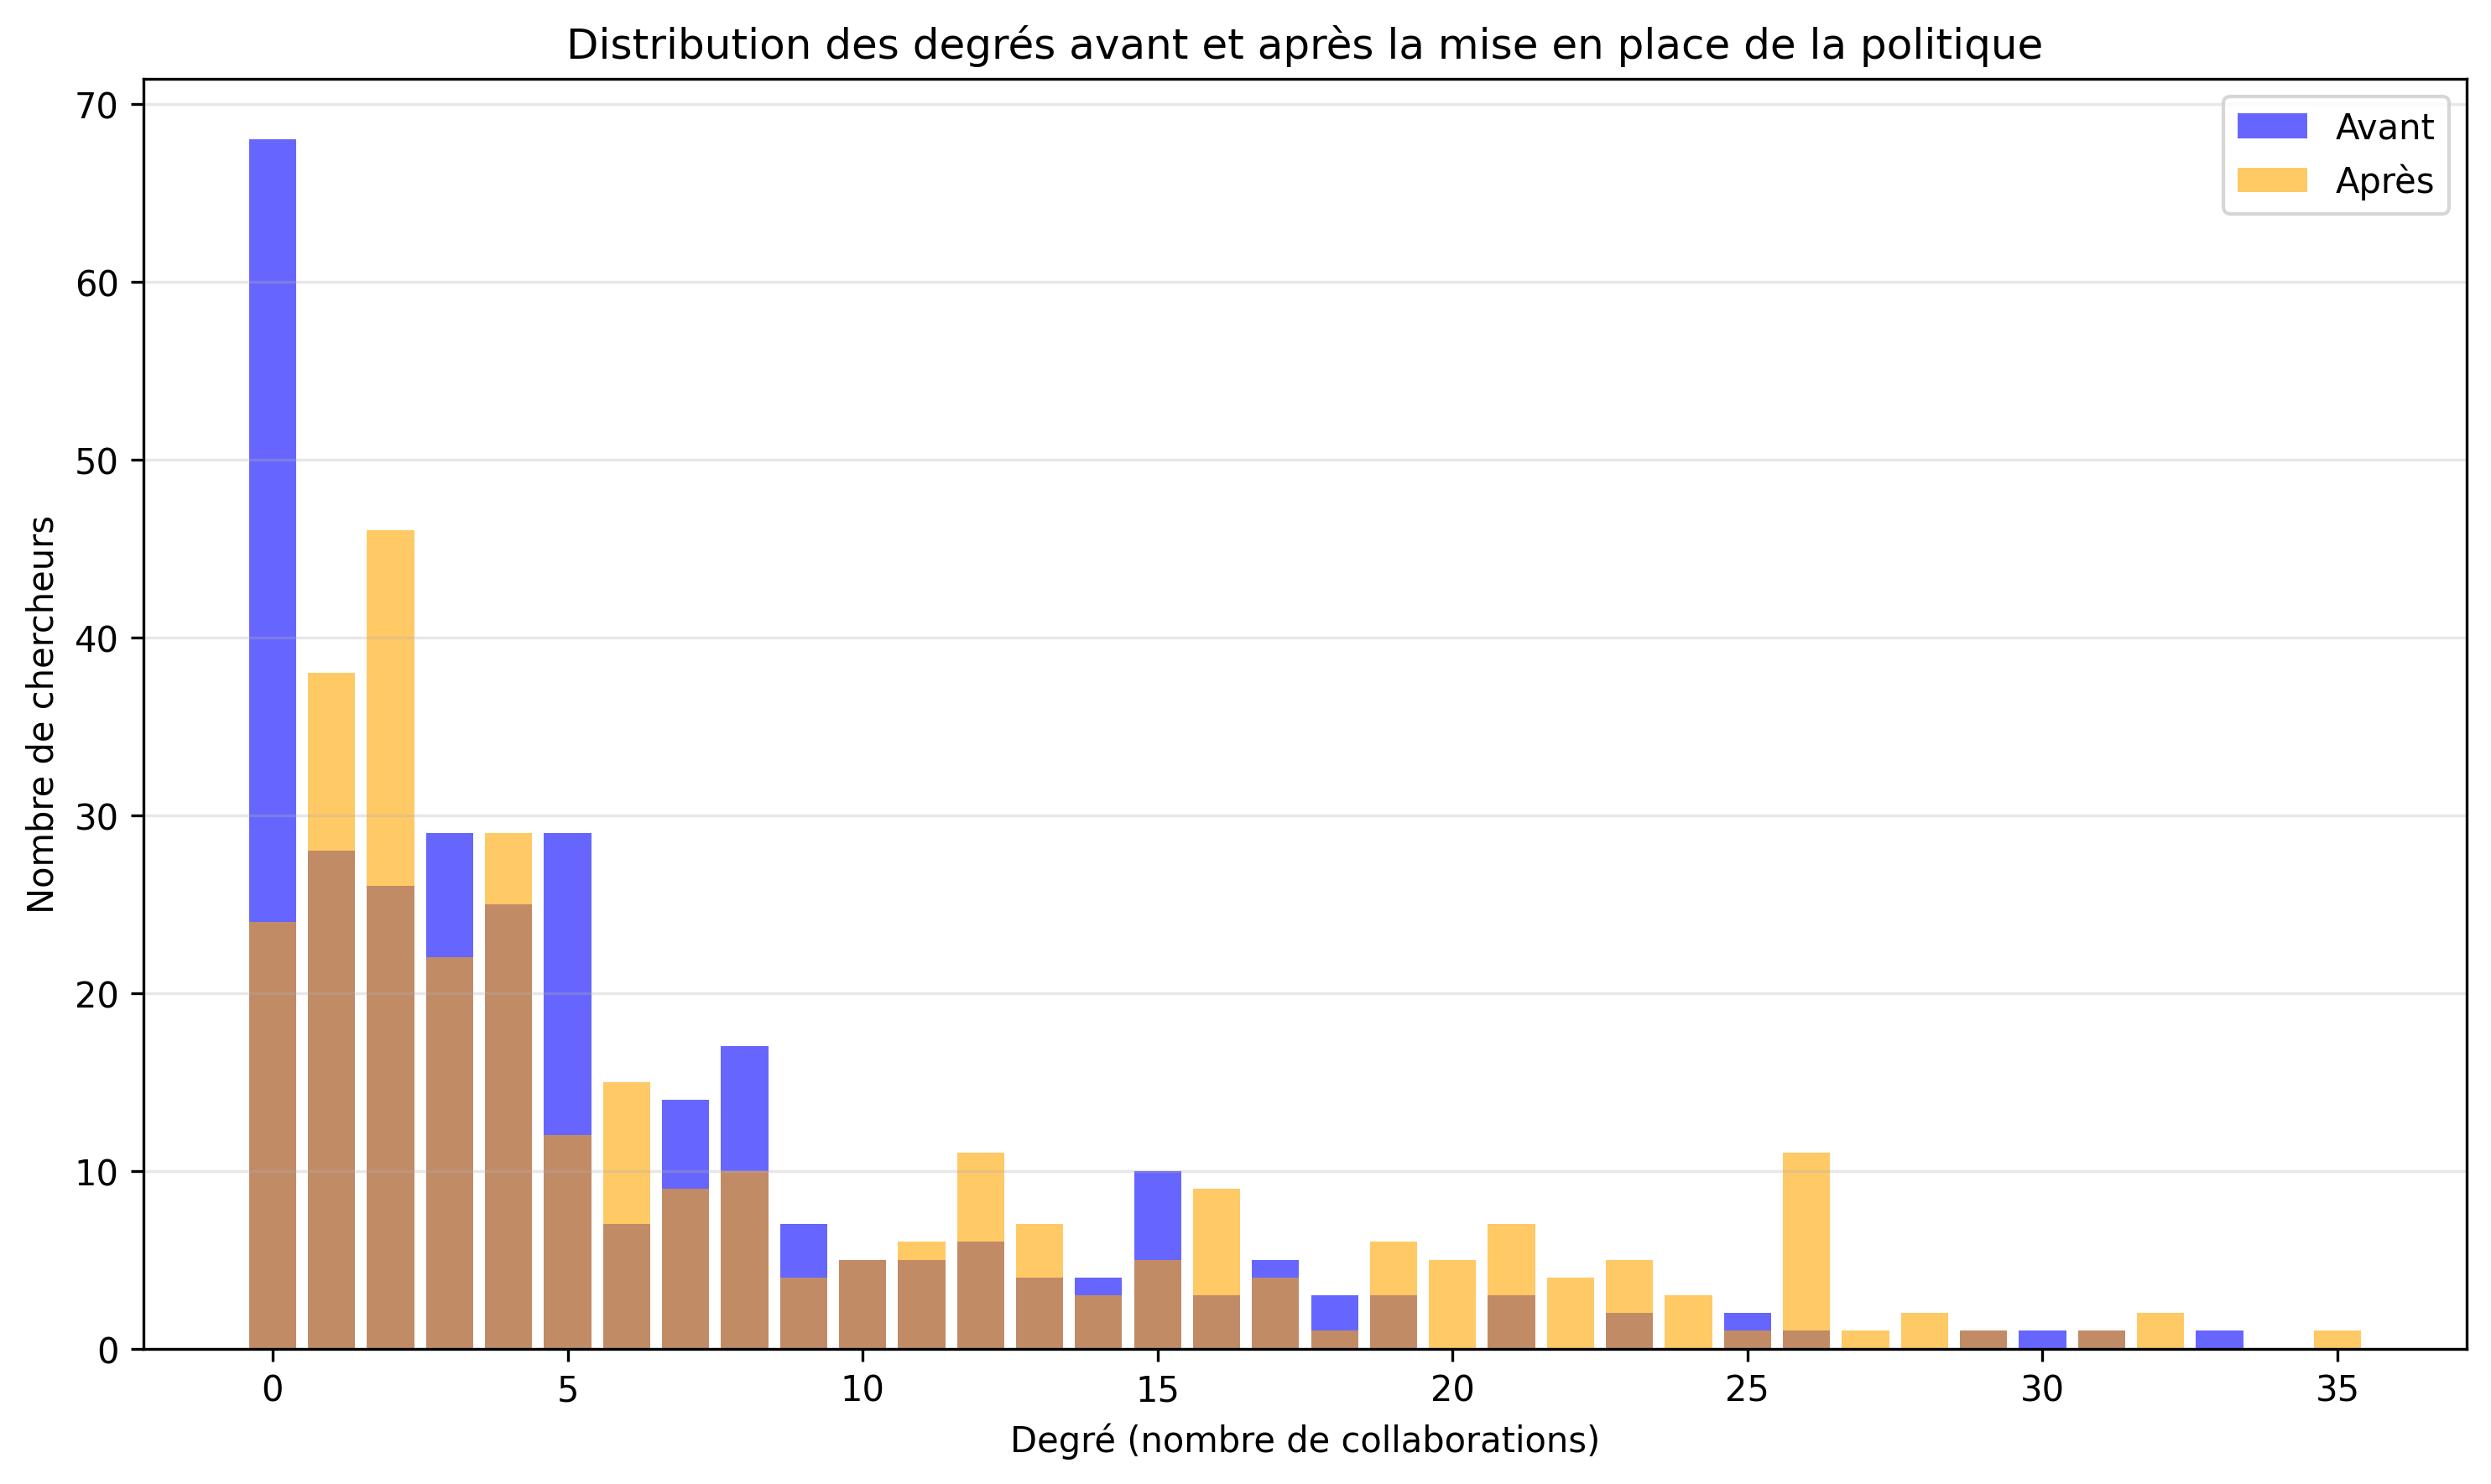

In [85]:
# Distribution des degr√©s dans le m√™me graphique
degree_count_pre = nx.degree_histogram(G_pre)
degree_count_post = nx.degree_histogram(G_post)

# Assurer que les deux listes ont la m√™me longueur
max_len = max(len(degree_count_pre), len(degree_count_post))
degree_count_pre = degree_count_pre + [0] * (max_len - len(degree_count_pre))
degree_count_post = degree_count_post + [0] * (max_len - len(degree_count_post))

# Cr√©ation du graphique
fig, ax = plt.subplots(figsize=(10, 6), dpi=300)
degree_range = np.arange(max_len)

ax.bar(degree_range, degree_count_pre, label="Avant", alpha=0.6, color='blue')
ax.bar(degree_range, degree_count_post, label="Apr√®s", alpha=0.6, color='orange')

ax.legend(loc="best")
ax.set_xlabel("Degr√© (nombre de collaborations)")
ax.set_ylabel("Nombre de chercheurs")
ax.set_title("Distribution des degr√©s avant et apr√®s la mise en place de la politique")
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_distribution_comparison.png', dpi=300)
plt.show()

### **Interpr√©tation du graphique : Distribution des degr√©s avant et apr√®s la mise en place de la politique**

1. **Observation g√©n√©rale :**
   - **Avant la politique (barres bleues) :**
     - La majorit√© des chercheurs ont un faible degr√© (entre 0 et 5 collaborations).
     - Tr√®s peu de chercheurs ont un degr√© √©lev√© (au-del√† de 15 collaborations), ce qui indique une structure fragment√©e avec peu de hubs (n≈ìuds tr√®s connect√©s).
   - **Apr√®s la politique (barres jaunes) :**
     - On observe une augmentation notable du nombre de chercheurs avec un degr√© moyen (entre 5 et 15 collaborations).
     - Le nombre de chercheurs avec un degr√© √©lev√© (au-del√† de 20 collaborations) a √©galement augment√©, ce qui montre l'√©mergence ou le renforcement de hubs.

2. **Impact de la politique :**
   - La politique semble avoir favoris√© une augmentation des collaborations globales :
     - Les chercheurs faiblement connect√©s (degr√© 0 √† 2) ont vu leur degr√© diminuer, ce qui signifie qu'ils ont √©t√© mieux int√©gr√©s dans le r√©seau.
     - Les chercheurs avec un degr√© moyen ou √©lev√© ont vu leurs connexions augmenter, renfor√ßant leur r√¥le dans le r√©seau.
   - Cela refl√®te une meilleure connectivit√© et une r√©duction de la fragmentation du r√©seau.

3. **Structure du r√©seau :**
   - Avant la politique, le r√©seau √©tait plus fragment√©, avec une majorit√© de chercheurs faiblement connect√©s.
   - Apr√®s la politique, le r√©seau est devenu plus dense et inclusif, avec une meilleure r√©partition des connexions entre les chercheurs.

4. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique montre que la politique a eu un effet structurant :
     - Elle a permis d'int√©grer davantage de chercheurs faiblement connect√©s.
     - Elle a renforc√© les collaborations pour les chercheurs d√©j√† bien connect√©s.
   - Cela peut √™tre interpr√©t√© comme une am√©lioration de la coh√©sion et de l'inclusivit√© du r√©seau.

---

### **Conclusion :**
La politique semble avoir eu un impact positif sur le r√©seau en augmentant les connexions globales et en r√©duisant la fragmentation. Elle a permis d'int√©grer les chercheurs faiblement connect√©s tout en renfor√ßant les hubs existants. Pour aller plus loin, il serait int√©ressant d'examiner si ces changements b√©n√©ficient √©quitablement √† tous les groupes (par exemple, hommes/femmes, core/non-core).

In [87]:
# Calcul des centralit√©s
def get_centrality_df(G):
    return pd.DataFrame({
        'node': list(G.nodes()),
        'degree': [d for _, d in G.degree()],
        'betweenness': list(nx.betweenness_centrality(G).values()),
        'closeness': list(nx.closeness_centrality(G).values())
    })

pre_cent = get_centrality_df(G_pre)
post_cent = get_centrality_df(G_post)


# Fusion avec attributs
pre_cent = pre_cent.merge(nodes, left_on='node', right_on='id')
post_cent = post_cent.merge(nodes, left_on='node', right_on='id')

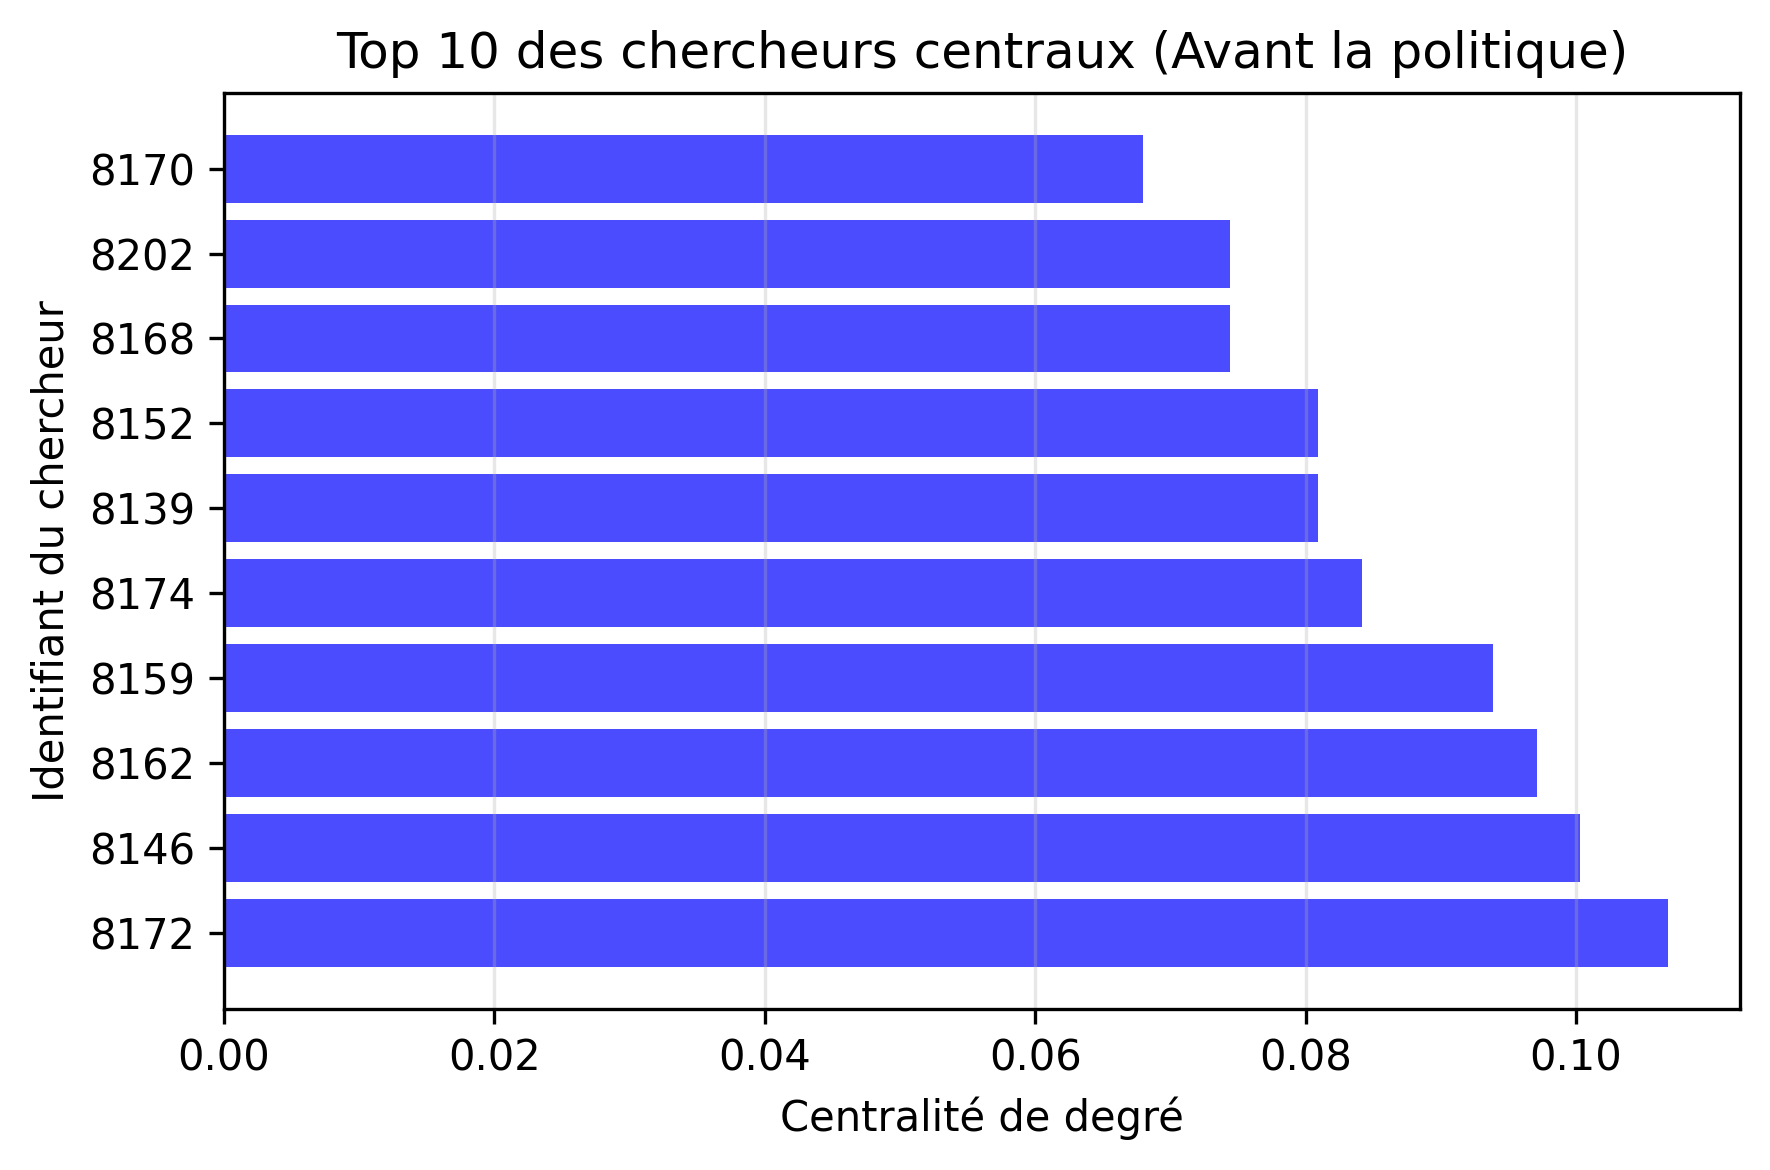

In [90]:
# Top 10 des chercheurs centraux avant la politique
number_of_element_to_inspect = 10
degree_centrality = nx.degree_centrality(G_pre)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Pr√©paration des donn√©es pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Cr√©ation du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='blue', alpha=0.7)
plt.xlabel("Centralit√© de degr√©")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_central_researchers_pre.png', dpi=300)
plt.show()


### **Interpr√©tation du graphique : Top 10 des chercheurs par centralit√© de degr√© (post-politique)**

1. **Observation g√©n√©rale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralit√© de degr√©** dans le r√©seau apr√®s la mise en place de la politique.
   - La centralit√© de degr√© est une mesure de l'importance d'un n≈ìud dans le r√©seau, bas√©e sur le nombre de connexions directes qu'il poss√®de par rapport au total des connexions possibles.

2. **Analyse des r√©sultats :**
   - Le chercheur avec l'identifiant `74874` a la centralit√© de degr√© la plus √©lev√©e, atteignant environ **0.10**. Cela signifie qu'il est directement connect√© √† **10% des autres chercheurs** du r√©seau.
   - Les autres chercheurs du top 10 ont des centralit√©s l√©g√®rement inf√©rieures, mais restent parmi les plus connect√©s, avec des valeurs comprises entre **0.06** et **0.10**.
   - Ces chercheurs jouent un r√¥le cl√© dans le r√©seau en tant que **hubs**, connectant de nombreux autres chercheurs et facilitant les collaborations.

3. **Impact de la politique :**
   - Si ce graphique repr√©sente le r√©seau **post-politique**, cela pourrait indiquer que la politique a renforc√© la position de ces chercheurs centraux ou permis √† certains d'entre eux d'augmenter leur centralit√©.
   - Il serait int√©ressant de comparer ces r√©sultats avec ceux du r√©seau **pr√©-politique** pour voir si ces chercheurs √©taient d√©j√† centraux ou si leur centralit√© a augment√© gr√¢ce √† la politique.

4. **Structure du r√©seau :**
   - La pr√©sence de chercheurs avec une centralit√© √©lev√©e montre que le r√©seau est structur√© autour de quelques individus tr√®s connect√©s, qui agissent comme des facilitateurs de collaborations.
   - Ces hubs sont essentiels pour maintenir la coh√©sion du r√©seau et pour diffuser les informations ou les opportunit√©s de collaboration.

5. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique met en √©vidence les individus les plus influents dans le r√©seau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs centraux appartiennent √† des groupes sp√©cifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favoris√© l'√©mergence de nouveaux hubs.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un r√¥le central dans le r√©seau, connectant un grand nombre d'autres chercheurs. Ces individus sont essentiels pour la coh√©sion et la diffusion des collaborations dans le r√©seau. Si la politique a permis √† de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralit√©, cela pourrait √™tre interpr√©t√© comme un effet positif de la politique sur l'inclusivit√© et la connectivit√© du r√©seau.

Souhaitez-vous comparer ces r√©sultats avec ceux du r√©seau pr√©-politique ou approfondir l'analyse pour des groupes sp√©cifiques ? üòä

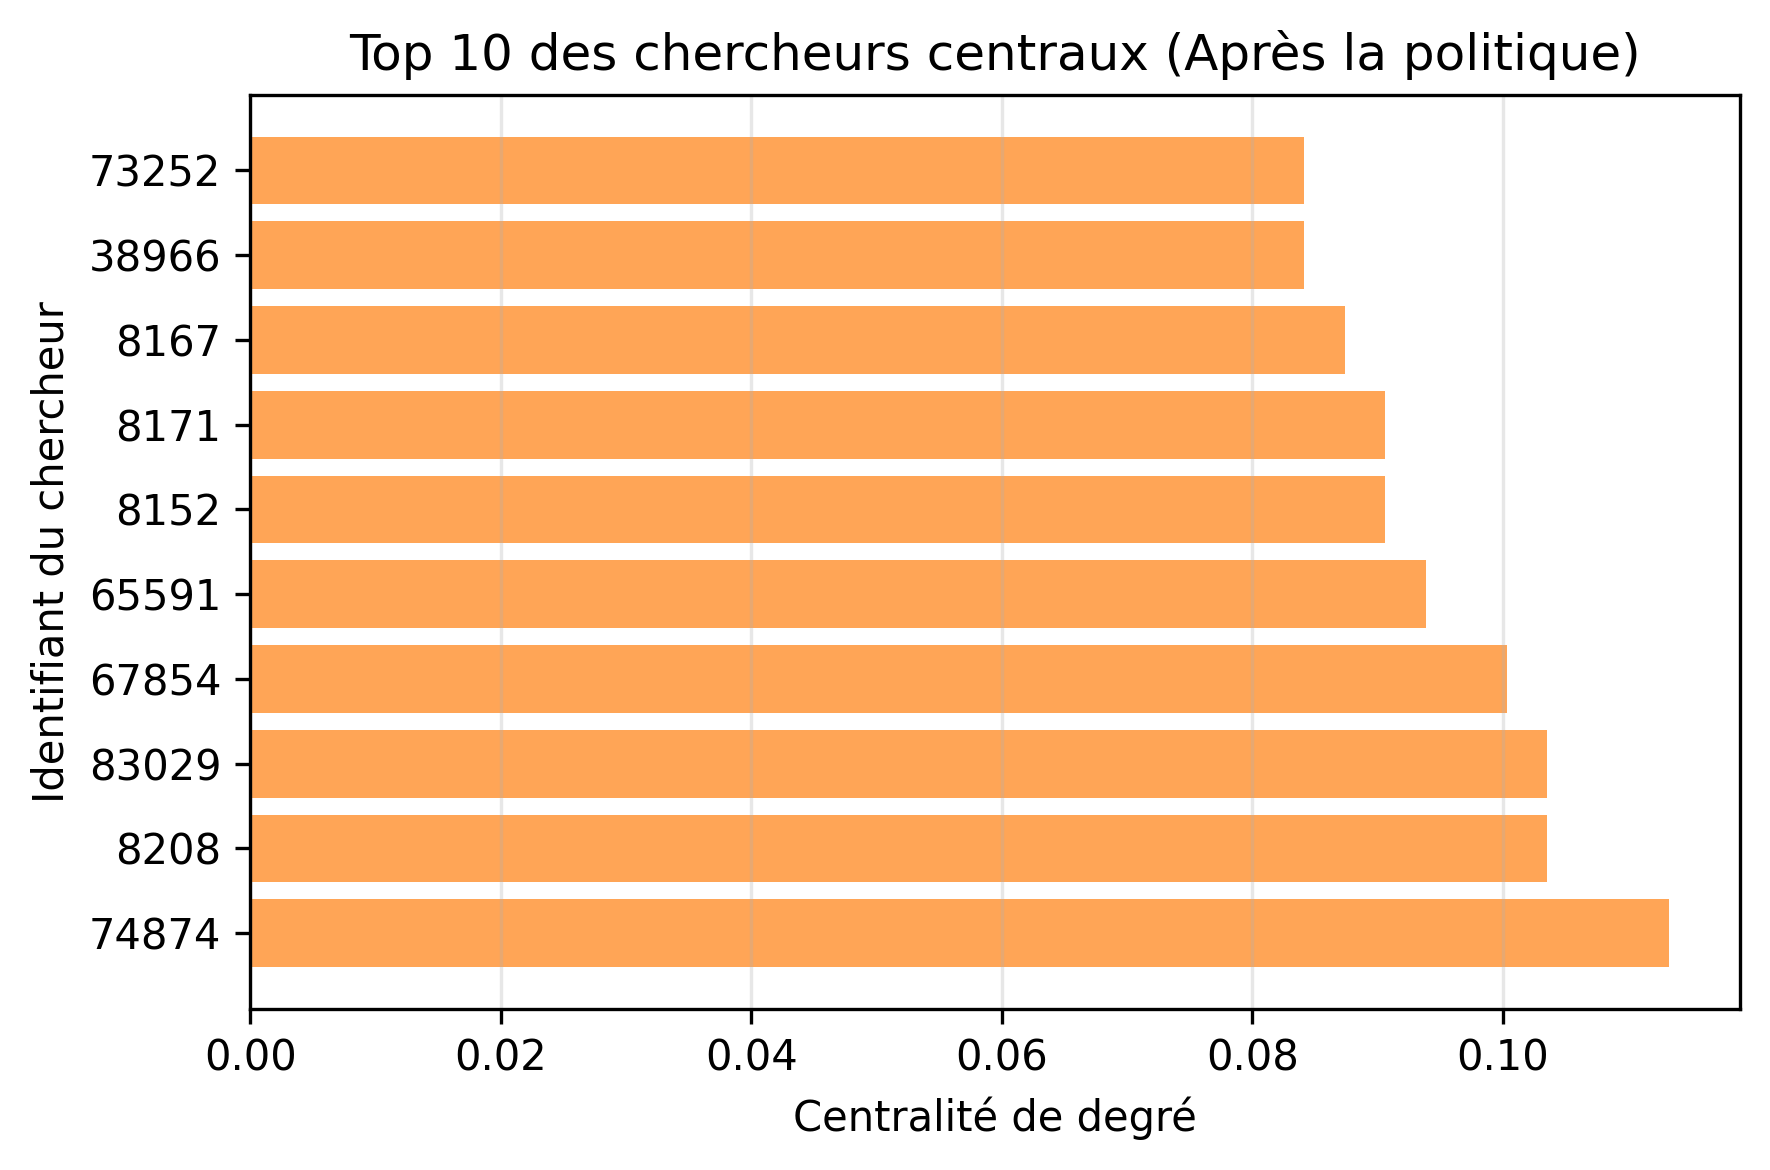

In [93]:
# Top 10 des chercheurs centraux apr√®s la politique
number_of_element_to_inspect = 10
degree_centrality = nx.degree_centrality(G_post)
top_nodes = sorted(degree_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Pr√©paration des donn√©es pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Cr√©ation du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='tab:orange', alpha=0.7)
plt.xlabel("Centralit√© de degr√©")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Apr√®s la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_central_researchers_post.png', dpi=300)
plt.show()

### **Interpr√©tation du graphique : Top 10 des chercheurs par centralit√© de degr√© (post-politique)**

1. **Observation g√©n√©rale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralit√© de degr√©** dans le r√©seau apr√®s la mise en place de la politique.
   - La centralit√© de degr√© est une mesure de l'importance d'un n≈ìud dans le r√©seau, bas√©e sur le nombre de connexions directes qu'il poss√®de par rapport au total des connexions possibles.

2. **Analyse des r√©sultats :**
   - Le chercheur avec l'identifiant `74874` a la centralit√© de degr√© la plus √©lev√©e, atteignant environ **0.10**. Cela signifie qu'il est directement connect√© √† **10% des autres chercheurs** du r√©seau.
   - Les autres chercheurs du top 10 ont des centralit√©s l√©g√®rement inf√©rieures, mais restent parmi les plus connect√©s, avec des valeurs comprises entre **0.06** et **0.10**.
   - Ces chercheurs jouent un r√¥le cl√© dans le r√©seau en tant que **hubs**, connectant de nombreux autres chercheurs et facilitant les collaborations.

3. **Impact de la politique :**
   - Si ce graphique repr√©sente le r√©seau **post-politique**, cela pourrait indiquer que la politique a renforc√© la position de ces chercheurs centraux ou permis √† certains d'entre eux d'augmenter leur centralit√©.
   - Il serait int√©ressant de comparer ces r√©sultats avec ceux du r√©seau **pr√©-politique** pour voir si ces chercheurs √©taient d√©j√† centraux ou si leur centralit√© a augment√© gr√¢ce √† la politique.

4. **Structure du r√©seau :**
   - La pr√©sence de chercheurs avec une centralit√© √©lev√©e montre que le r√©seau est structur√© autour de quelques individus tr√®s connect√©s, qui agissent comme des facilitateurs de collaborations.
   - Ces hubs sont essentiels pour maintenir la coh√©sion du r√©seau et pour diffuser les informations ou les opportunit√©s de collaboration.

5. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique met en √©vidence les individus les plus influents dans le r√©seau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs centraux appartiennent √† des groupes sp√©cifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favoris√© l'√©mergence de nouveaux hubs.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un r√¥le central dans le r√©seau, connectant un grand nombre d'autres chercheurs. Ces individus sont essentiels pour la coh√©sion et la diffusion des collaborations dans le r√©seau. Si la politique a permis √† de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralit√©, cela pourrait √™tre interpr√©t√© comme un effet positif de la politique sur l'inclusivit√© et la connectivit√© du r√©seau.

Souhaitez-vous comparer ces r√©sultats avec ceux du r√©seau pr√©-politique ou approfondir l'analyse pour des groupes sp√©cifiques ? üòä

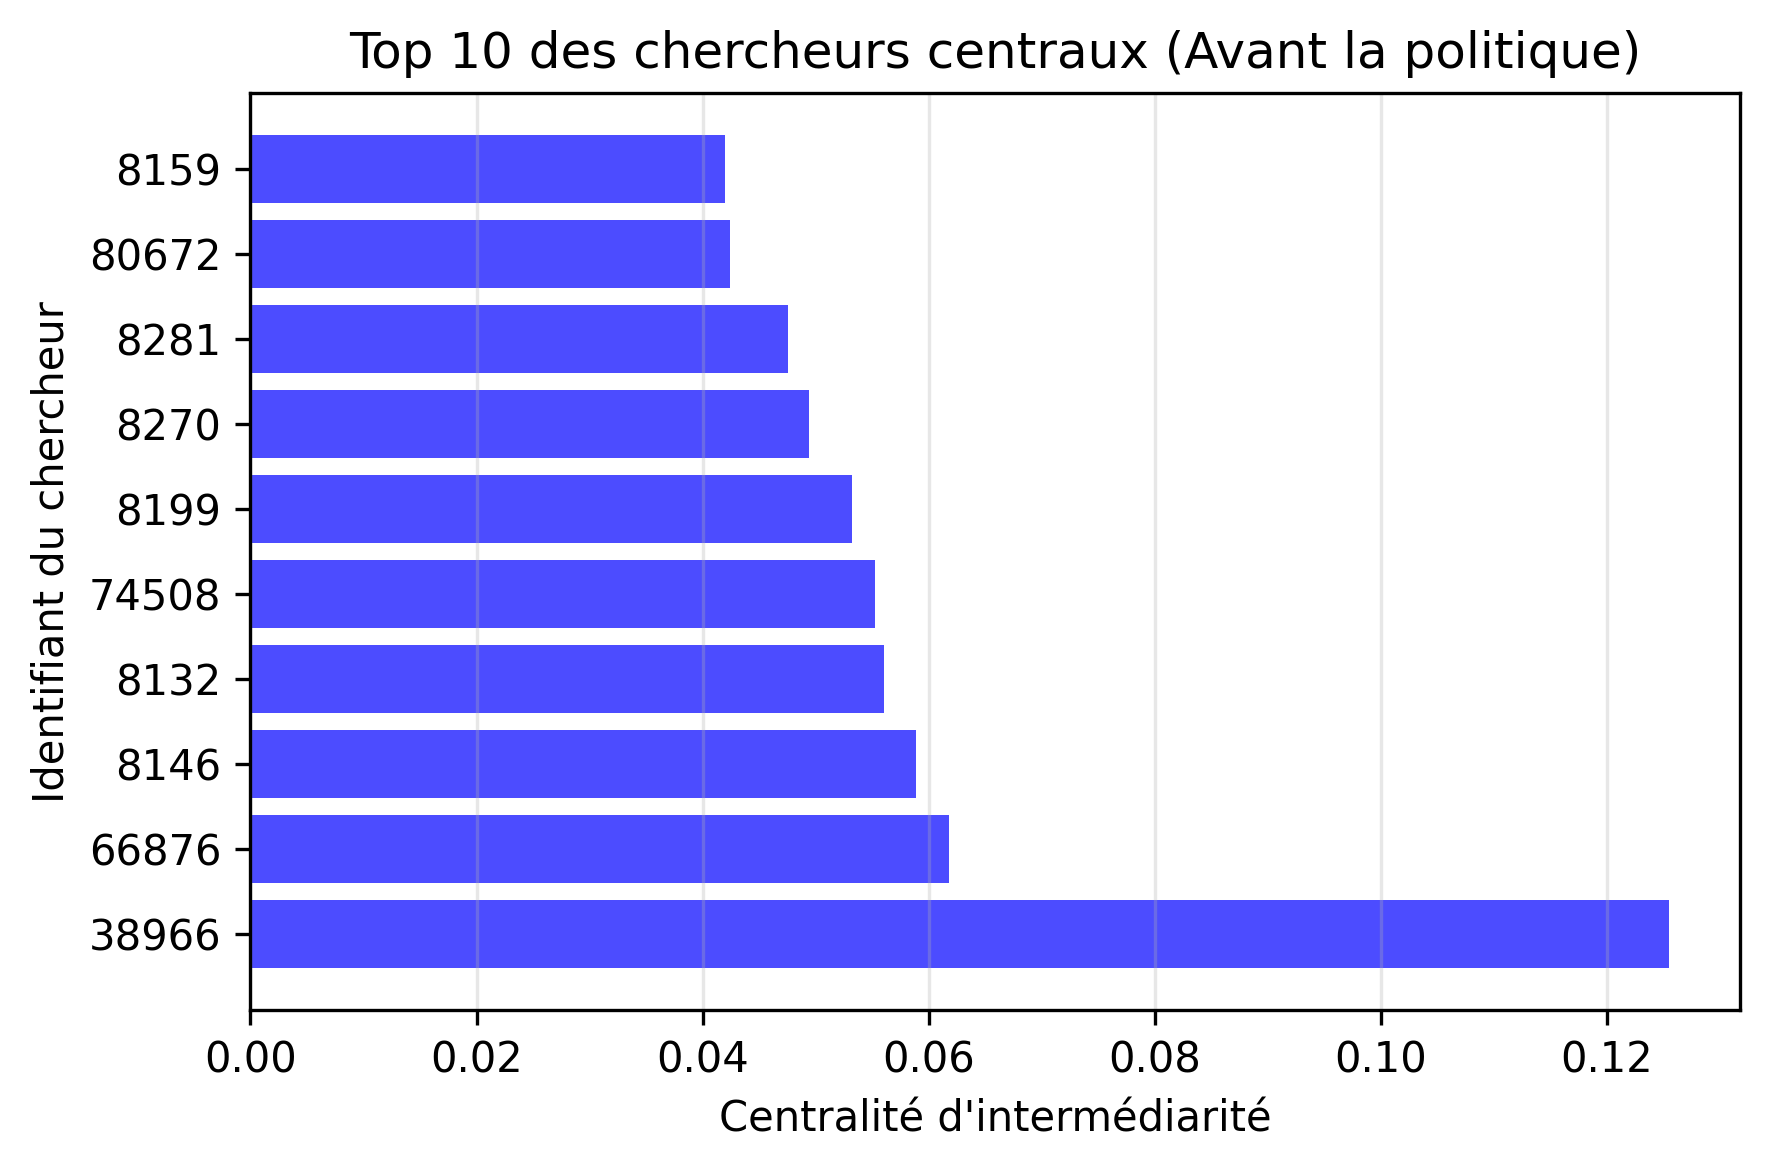

In [96]:
# Top 10 des chercheurs par centralit√© d'interm√©diarit√© avant la politique
number_of_element_to_inspect = 10
betweenness_centrality = nx.betweenness_centrality(G_pre)
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Pr√©paration des donn√©es pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Cr√©ation du graphique
plt.figure(figsize=(6, 4), dpi=300)
plt.barh(nodes_ids, centrality_values, color='blue', alpha=0.7)
plt.xlabel("Centralit√© d'interm√©diarit√©")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Avant la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_betweenness_researchers_pre.png', dpi=300)
plt.show()

### **Interpr√©tation du graphique : Top 10 des chercheurs par centralit√© d'interm√©diarit√©**

1. **Observation g√©n√©rale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralit√© d'interm√©diarit√©** dans le r√©seau.
   - La centralit√© d'interm√©diarit√© mesure l'importance d'un n≈ìud en tant que **pont** dans le r√©seau, c'est-√†-dire sa capacit√© √† connecter diff√©rentes parties du r√©seau en passant par lui.

2. **Analyse des r√©sultats :**
   - Le chercheur avec l'identifiant `38966` a la centralit√© d'interm√©diarit√© la plus √©lev√©e, atteignant environ **0.12**. Cela signifie qu'il joue un r√¥le cl√© dans la connexion entre diff√©rents groupes ou sous-r√©seaux.
   - Les autres chercheurs du top 10 ont des centralit√©s d'interm√©diarit√© comprises entre **0.04** et **0.08**, ce qui montre qu'ils ont √©galement une importance significative, mais moindre par rapport au premier.

3. **Structure du r√©seau :**
   - Ces chercheurs agissent comme des **interm√©diaires** ou des **facilitateurs** dans le r√©seau, reliant des groupes qui, autrement, pourraient √™tre isol√©s.
   - Leur r√¥le est essentiel pour maintenir la coh√©sion du r√©seau et pour permettre la diffusion des informations ou des opportunit√©s de collaboration.

4. **Impact de la politique :**
   - Si ce graphique repr√©sente le r√©seau **post-politique**, cela pourrait indiquer que la politique a renforc√© le r√¥le de ces chercheurs en tant qu'interm√©diaires ou a permis √† de nouveaux chercheurs de jouer ce r√¥le.
   - Il serait int√©ressant de comparer ces r√©sultats avec ceux du r√©seau **pr√©-politique** pour voir si ces chercheurs √©taient d√©j√† des interm√©diaires importants ou si leur centralit√© d'interm√©diarit√© a augment√© gr√¢ce √† la politique.

5. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique met en √©vidence les individus qui jouent un r√¥le strat√©gique dans le r√©seau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs appartiennent √† des groupes sp√©cifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favoris√© l'√©mergence de nouveaux interm√©diaires.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un r√¥le crucial en tant qu'interm√©diaires dans le r√©seau, connectant diff√©rentes parties du r√©seau et facilitant les collaborations. Si la politique a permis √† de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralit√© d'interm√©diarit√©, cela pourrait √™tre interpr√©t√© comme un effet positif de la politique sur la connectivit√© et la coh√©sion du r√©seau.

Souhaitez-vous comparer ces r√©sultats avec ceux du r√©seau pr√©-politique ou examiner les changements pour des groupes sp√©cifiques ? üòä

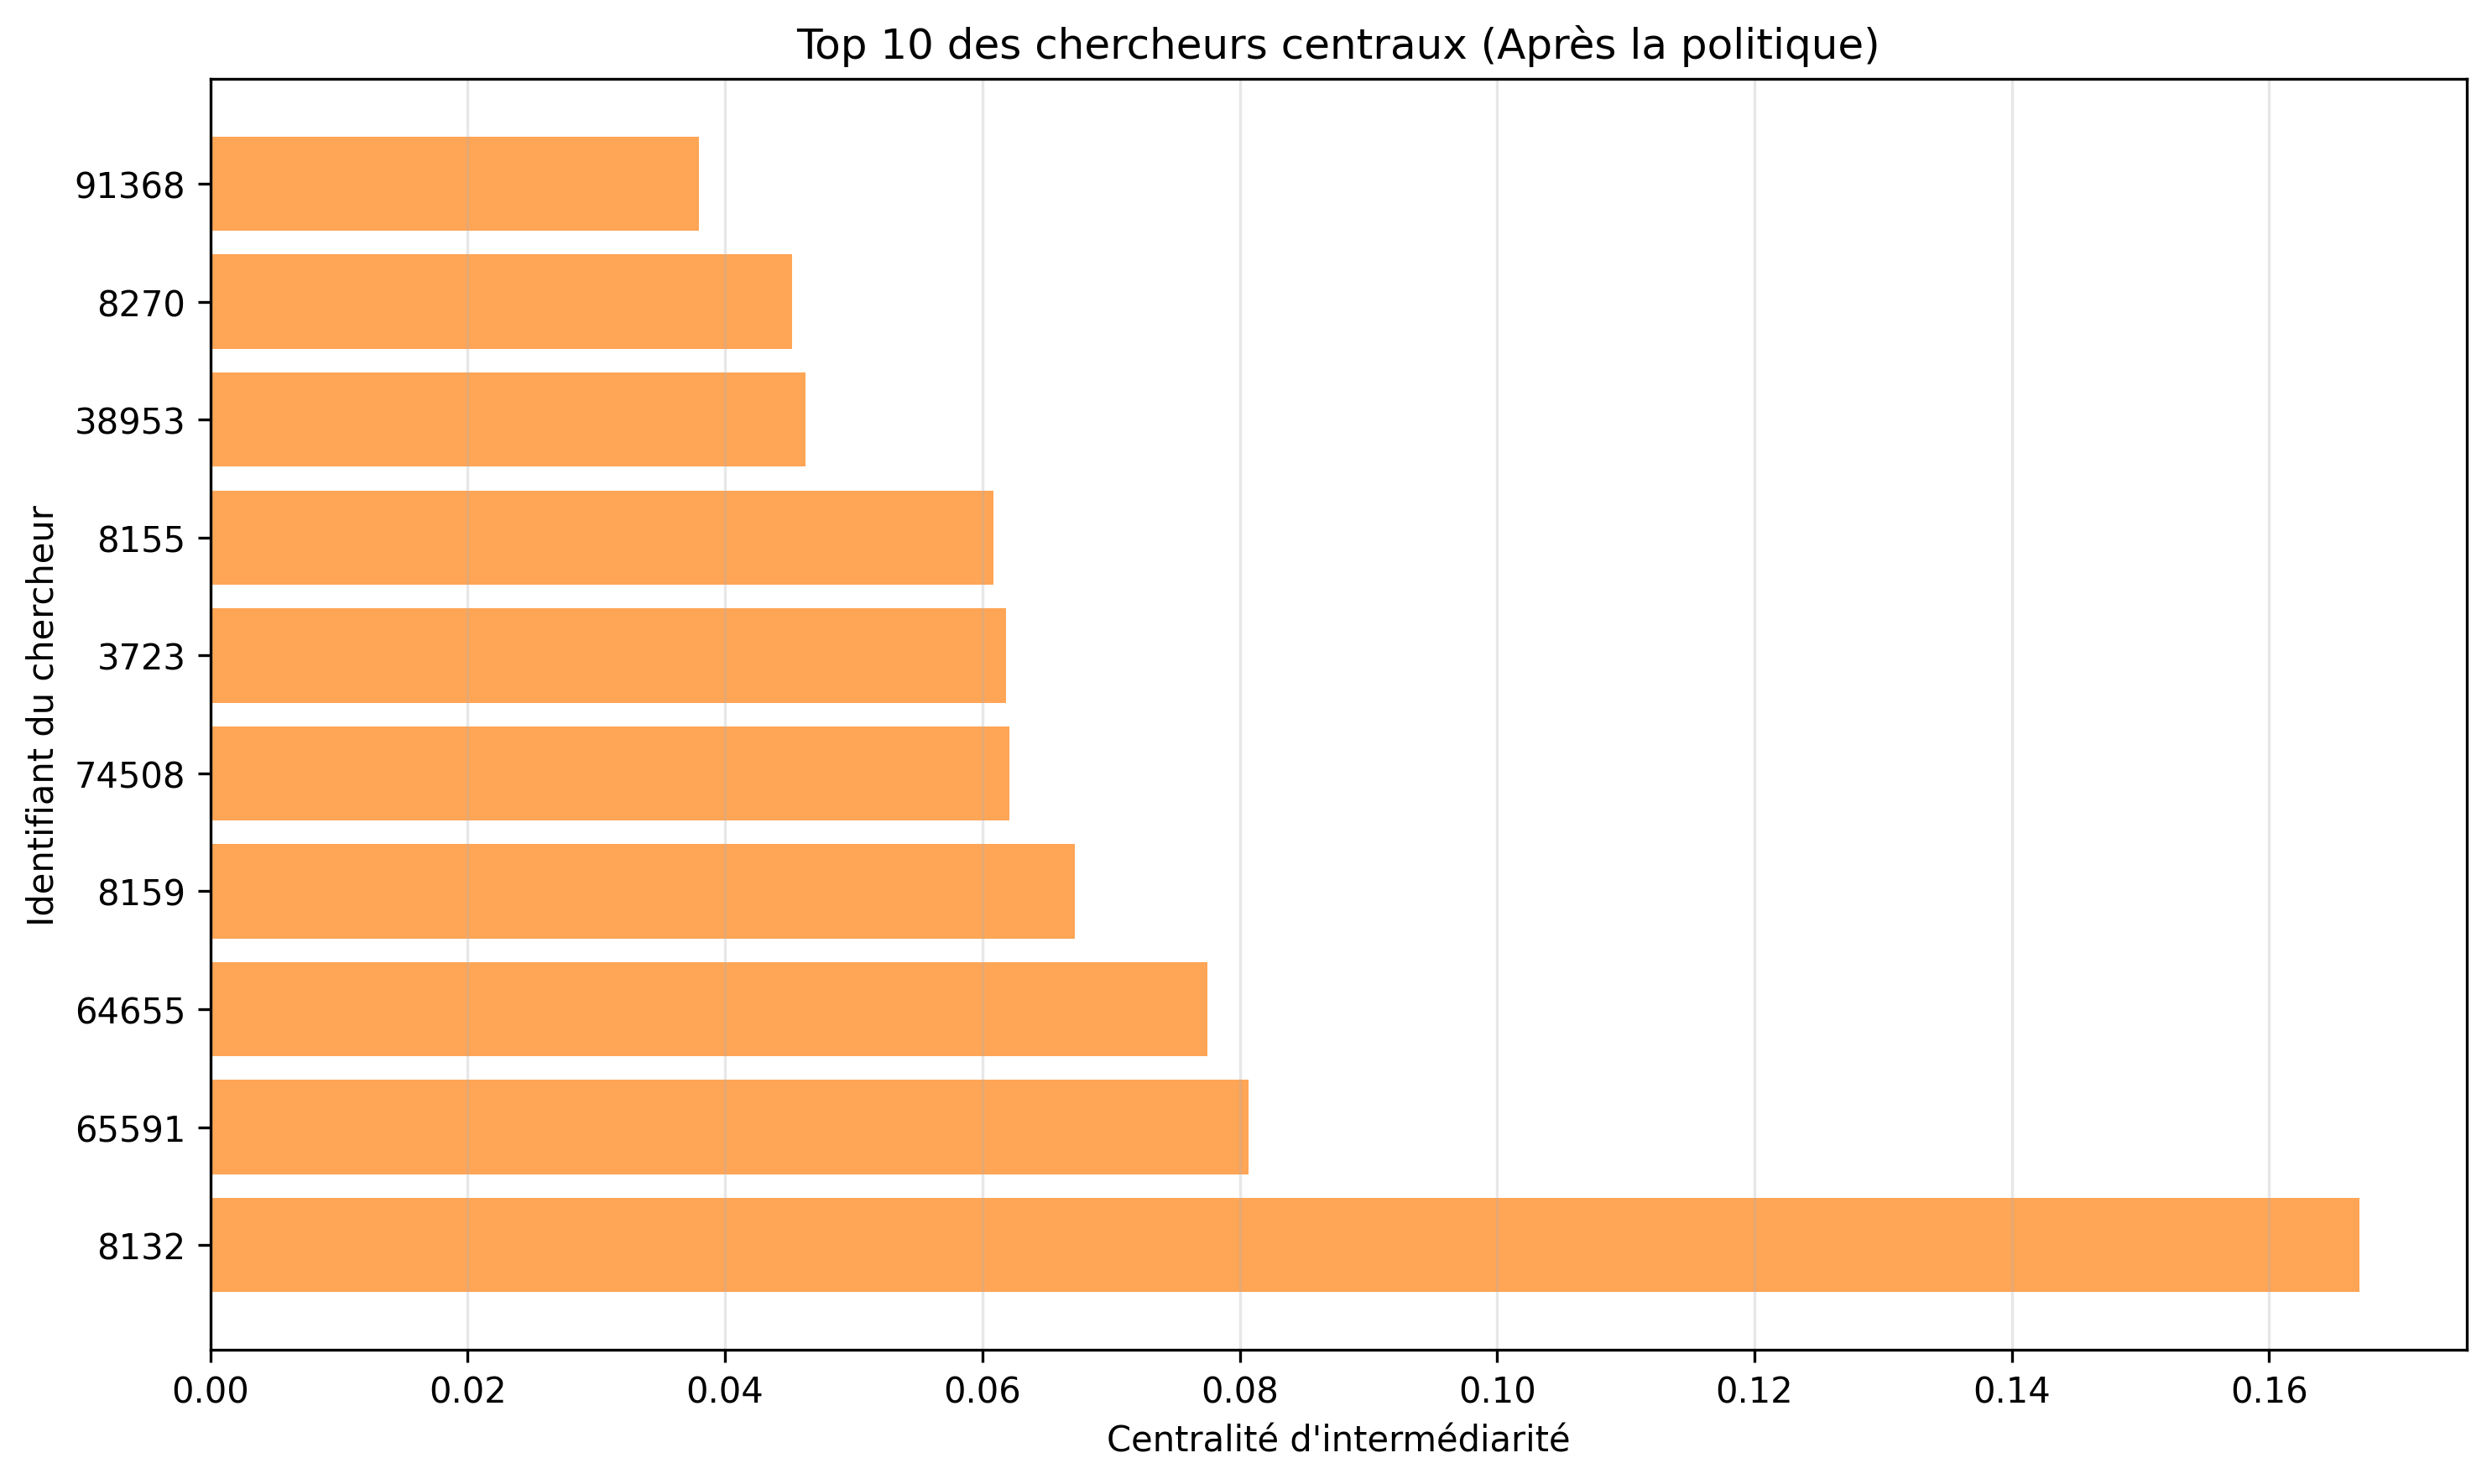

In [99]:
# Top 10 des chercheurs par centralit√© d'interm√©diarit√© apr√®s la politique
number_of_element_to_inspect = 10
betweenness_centrality = nx.betweenness_centrality(G_post)
top_nodes = sorted(betweenness_centrality.items(), key=lambda x: x[1], reverse=True)[:number_of_element_to_inspect]

# Pr√©paration des donn√©es pour le graphique
nodes_ids = [str(n) for n, _ in top_nodes]
centrality_values = [c for _, c in top_nodes]

# Cr√©ation du graphique
plt.figure(figsize=(10, 6), dpi=300)
plt.barh(nodes_ids, centrality_values, color='tab:orange', alpha=0.7)
plt.xlabel("Centralit√© d'interm√©diarit√©")
plt.ylabel("Identifiant du chercheur")
plt.title(f"Top {number_of_element_to_inspect} des chercheurs centraux (Apr√®s la politique)")
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.savefig('top_betweenness_researchers_post.png', dpi=300)
plt.show()

### **Interpr√©tation du graphique : Top 10 des chercheurs par centralit√© d'interm√©diarit√© (post-politique)**

1. **Observation g√©n√©rale :**
   - Le graphique montre les 10 chercheurs ayant la plus grande **centralit√© d'interm√©diarit√©** dans le r√©seau apr√®s la mise en place de la politique.
   - La centralit√© d'interm√©diarit√© mesure l'importance d'un chercheur en tant que **pont** dans le r√©seau, c'est-√†-dire sa capacit√© √† connecter diff√©rentes parties du r√©seau en passant par lui.

2. **Analyse des r√©sultats :**
   - Le chercheur avec l'identifiant **8132** a la centralit√© d'interm√©diarit√© la plus √©lev√©e, atteignant environ **0.16**. Cela signifie qu'il joue un r√¥le cl√© dans la connexion entre diff√©rents groupes ou sous-r√©seaux.
   - Les autres chercheurs du top 10 ont des centralit√©s d'interm√©diarit√© comprises entre **0.04** et **0.08**, ce qui montre qu'ils ont √©galement une importance significative, mais moindre par rapport au premier.
   - Ces chercheurs sont des **interm√©diaires strat√©giques**, reliant des parties du r√©seau qui, autrement, pourraient √™tre isol√©es.

3. **Structure du r√©seau :**
   - La pr√©sence de chercheurs avec une centralit√© d'interm√©diarit√© √©lev√©e montre que le r√©seau est structur√© autour de quelques individus jouant un r√¥le de **facilitateurs** ou de **connecteurs**.
   - Ces chercheurs sont essentiels pour maintenir la coh√©sion du r√©seau et pour permettre la diffusion des informations ou des opportunit√©s de collaboration.

4. **Impact de la politique :**
   - Si ce graphique repr√©sente le r√©seau **post-politique**, cela pourrait indiquer que la politique a renforc√© le r√¥le de ces chercheurs en tant qu'interm√©diaires ou a permis √† de nouveaux chercheurs de jouer ce r√¥le.
   - Il serait int√©ressant de comparer ces r√©sultats avec ceux du r√©seau **pr√©-politique** pour voir si ces chercheurs √©taient d√©j√† des interm√©diaires importants ou si leur centralit√© d'interm√©diarit√© a augment√© gr√¢ce √† la politique.

5. **Lien avec votre projet :**
   - Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique met en √©vidence les individus qui jouent un r√¥le strat√©gique dans le r√©seau.
   - Vous pourriez approfondir l'analyse pour examiner si ces chercheurs appartiennent √† des groupes sp√©cifiques (par exemple, hommes/femmes, core/non-core) et si la politique a favoris√© l'√©mergence de nouveaux interm√©diaires.

---

### **Conclusion :**
Le graphique montre que certains chercheurs jouent un r√¥le crucial en tant qu'interm√©diaires dans le r√©seau, connectant diff√©rentes parties du r√©seau et facilitant les collaborations. Si la politique a permis √† de nouveaux chercheurs de rejoindre ce top 10 ou d'augmenter leur centralit√© d'interm√©diarit√©, cela pourrait √™tre interpr√©t√© comme un effet positif de la politique sur la connectivit√© et la coh√©sion du r√©seau.




## Objectif 2

    Est-ce que les femmes ont un r√©seau plus dense que celui des hommes ?
    Est-ce que les femmes sont plus central dans le r√©seau que les hommes ?
    Elargissent-elles plus/moins leur r√©seau par rapport aux hommes b√©n√©ficiant du traitement (au fil du temps) ?
    Peut-on identifier des sous communaut√© ou detecter de l'homophilie √† l'int√©rieur du r√©seaux avant et apr√®s la mise en place de la politique ?
    Comment cela √©volue t'il apr√®s la mise en place de la politique ?
    L'appartenance au groupe des coordinateurs modifie-t-elle ces √©volutions ?

Est-ce que les femmes ont un r√©seau plus dense que celui des hommes ?

L'approche que nous apdotons pour r√©pondre √† cette question, consiste √† calculer le degr√© moyen (correspondant au nombre de collaborations en moyenne) pour chaque genre sur l'ensemble du graphe et sur les deux p√©riodes donn√©es. Ainsi nous pourrons oberv√©s si entre les deux p√©riodes les femmes poss√©dait plus de collaboration en moyenne.


--------------------------------------------------------------------------------
Degr√© moyen avant la mise en place de la politique
Degr√© moyen des hommes: 5.7265
Degr√© moyen des femmes: 5.2368
--------------------------------------------------------------------------------
Degr√© moyen apr√®s la mise en place de la politique
Degr√© moyen des hommes: 7.6026
Degr√© moyen des femmes: 9.6974
--------------------------------------------------------------------------------

Tableau r√©capitulatif des degr√©s moyens par genre:
    Genre  Degr√© moyen avant  Degr√© moyen apr√®s  √âvolution (%)
0  Hommes             5.7265             7.6026          32.76
1  Femmes             5.2368             9.6974          85.18


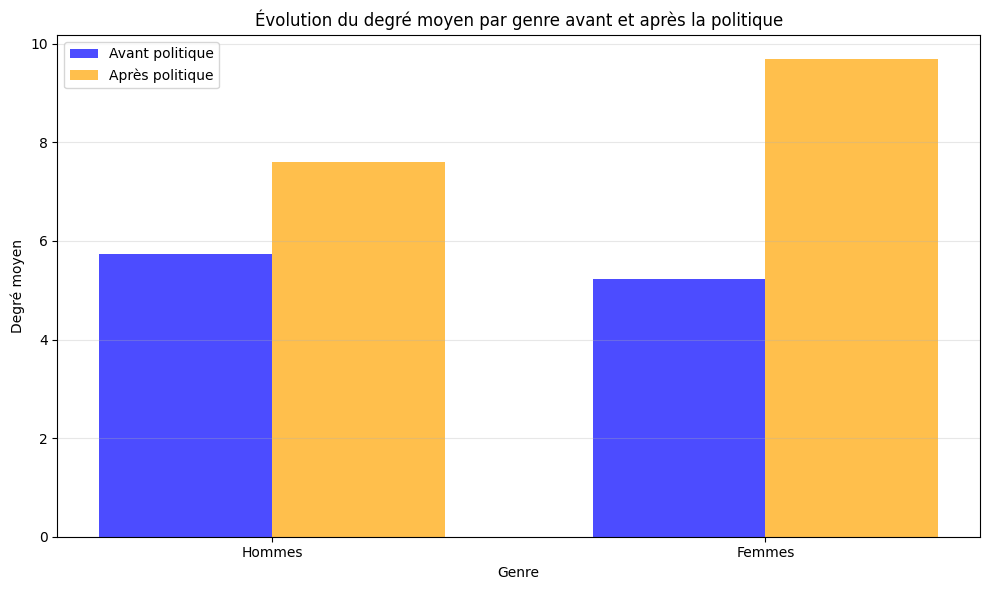

In [103]:
# Calcul du degr√© avant et apr√®s
degree_pre = dict(nx.degree(G_pre))
degree_post = dict(nx.degree(G_post))

# Identification des n≈ìuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Nombre de n≈ìuds de chaque genre
N_male = len(male_nodes)
N_female = len(female_nodes)

# Calcul du degr√© moyen pour les hommes et pour les femmes avant la politique
degree_sum_male_pre = sum(degree_pre[m_node] for m_node in male_nodes)
degree_sum_female_pre = sum(degree_pre[f_node] for f_node in female_nodes)

# Calcul du degr√© moyen pour les hommes et pour les femmes apr√®s la politique
degree_sum_male_post = sum(degree_post[m_node] for m_node in male_nodes)
degree_sum_female_post = sum(degree_post[f_node] for f_node in female_nodes)

# Calcul des moyennes
avg_degree_male_pre = degree_sum_male_pre / N_male
avg_degree_female_pre = degree_sum_female_pre / N_female
avg_degree_male_post = degree_sum_male_post / N_male
avg_degree_female_post = degree_sum_female_post / N_female

# Affichage des r√©sultats
print("-"*80)
print("Degr√© moyen avant la mise en place de la politique")
print(f"Degr√© moyen des hommes: {round(avg_degree_male_pre, 4)}")
print(f"Degr√© moyen des femmes: {round(avg_degree_female_pre, 4)}")
print("-"*80)
print("Degr√© moyen apr√®s la mise en place de la politique")
print(f"Degr√© moyen des hommes: {round(avg_degree_male_post, 4)}")
print(f"Degr√© moyen des femmes: {round(avg_degree_female_post, 4)}")
print("-"*80)

# Cr√©ation d'un tableau r√©capitulatif
degree_by_gender = pd.DataFrame({
    'Genre': ['Hommes', 'Femmes'],
    'Degr√© moyen avant': [round(avg_degree_male_pre, 4), round(avg_degree_female_pre, 4)],
    'Degr√© moyen apr√®s': [round(avg_degree_male_post, 4), round(avg_degree_female_post, 4)],
    '√âvolution (%)': [
        round((avg_degree_male_post - avg_degree_male_pre) / avg_degree_male_pre * 100, 2),
        round((avg_degree_female_post - avg_degree_female_pre) / avg_degree_female_pre * 100, 2)
    ]
})

print("\nTableau r√©capitulatif des degr√©s moyens par genre:")
print(degree_by_gender)

# Visualisation des r√©sultats
plt.figure(figsize=(10, 6))
bar_width = 0.35
index = np.arange(2)

plt.bar(index - bar_width/2, [avg_degree_male_pre, avg_degree_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_degree_male_post, avg_degree_female_post], 
        bar_width, label='Apr√®s politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Degr√© moyen')
plt.title('√âvolution du degr√© moyen par genre avant et apr√®s la politique')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('degree_by_gender.png', dpi=300)
plt.show()

### **Interpr√©tation du graphique : √âvolution du degr√© moyen par genre avant et apr√®s la politique**

#### **1. Observation g√©n√©rale :**
Le graphique compare le degr√© moyen des hommes et des femmes avant et apr√®s la mise en place de la politique. On observe une augmentation significative du degr√© moyen pour les deux genres, mais cette augmentation est beaucoup plus marqu√©e pour les femmes.

---

#### **2. Analyse des hommes :**
- Avant la politique, le degr√© moyen des hommes √©tait de **5.7265**, ce qui indique qu'en moyenne, chaque homme avait environ 6 collaborations.
- Apr√®s la politique, ce degr√© moyen passe √† **7.6026**, soit une augmentation de **32.76%**.
- Cette augmentation montre que la politique a eu un effet positif sur les collaborations des hommes, mais cet effet reste mod√©r√© compar√© √† celui observ√© pour les femmes.

---

#### **3. Analyse des femmes :**
- Avant la politique, le degr√© moyen des femmes √©tait de **5.2368**, l√©g√®rement inf√©rieur √† celui des hommes.
- Apr√®s la politique, ce degr√© moyen atteint **9.6974**, soit une augmentation impressionnante de **85.18%**.
- Cette augmentation montre que la politique a eu un impact beaucoup plus significatif sur les collaborations des femmes, leur permettant de rattraper et m√™me de d√©passer les hommes en termes de degr√© moyen.

---

#### **4. Impact de la politique :**
- La politique semble avoir contribu√© √† r√©duire les in√©galit√©s de collaboration entre les genres. Avant la politique, les hommes avaient un degr√© moyen l√©g√®rement sup√©rieur √† celui des femmes. Apr√®s la politique, les femmes ont non seulement rattrap√© leur retard, mais elles ont √©galement surpass√© les hommes en termes de collaborations moyennes.
- Cela peut √™tre interpr√©t√© comme un effet positif de la politique, favorisant l'inclusion et l'int√©gration des femmes dans le r√©seau.

---

#### **5. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ce graphique montre que la politique a eu un effet particuli√®rement b√©n√©fique pour les femmes, augmentant significativement leur degr√© moyen.
- Vous pourriez approfondir cette analyse pour examiner si cet effet est uniforme parmi les femmes (par exemple, en comparant les femmes "core" et "non-core") ou si certains sous-groupes en ont davantage b√©n√©fici√©.

---

### **Conclusion :**
La politique a eu un impact positif sur les collaborations pour les deux genres, mais cet impact est beaucoup plus marqu√© pour les femmes. Cela sugg√®re que la politique a contribu√© √† r√©duire les in√©galit√©s de genre dans le r√©seau, en favorisant l'int√©gration des femmes et en augmentant leur participation aux collaborations. Ce r√©sultat est un indicateur fort de l'efficacit√© de la politique en termes d'inclusivit√© et d'√©quit√©.

Analyse de la centralit√© par genre:
    Genre  Centralit√© de degr√© (Avant)  Centralit√© de degr√© (Apr√®s)  \
0  Hommes                       0.0185                       0.0246   
1  Femmes                       0.0169                       0.0314   

   √âvolution degr√© (%)  Centralit√© d'interm√©diarit√© (Avant)  \
0                32.76                               0.0046   
1                85.18                               0.0052   

   Centralit√© d'interm√©diarit√© (Apr√®s)  √âvolution interm√©diarit√© (%)  
0                               0.0051                         11.28  
1                               0.0070                         35.53  


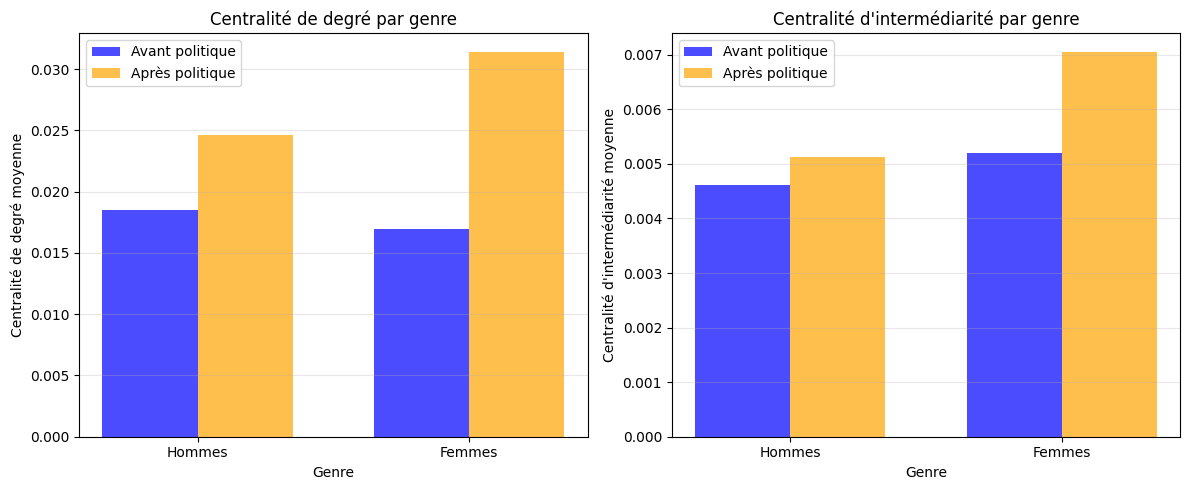


Tests statistiques pour comparer les centralit√©s entre hommes et femmes:
Centralit√© de degr√© avant: p-value = 0.5593
Centralit√© de degr√© apr√®s: p-value = 0.0553


In [106]:
# Calcul des centralit√©s avant et apr√®s la politique
degree_centra_pre = nx.degree_centrality(G_pre)
degree_centra_post = nx.degree_centrality(G_post)
between_centra_pre = nx.betweenness_centrality(G_pre)
between_centra_post = nx.betweenness_centrality(G_post)

# Identification des n≈ìuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Calcul des centralit√©s moyennes par genre
# Centralit√© de degr√©
avg_degree_cent_male_pre = np.mean([degree_centra_pre[n] for n in male_nodes])
avg_degree_cent_female_pre = np.mean([degree_centra_pre[n] for n in female_nodes])
avg_degree_cent_male_post = np.mean([degree_centra_post[n] for n in male_nodes])
avg_degree_cent_female_post = np.mean([degree_centra_post[n] for n in female_nodes])

# Centralit√© d'interm√©diarit√©
avg_between_cent_male_pre = np.mean([between_centra_pre[n] for n in male_nodes])
avg_between_cent_female_pre = np.mean([between_centra_pre[n] for n in female_nodes])
avg_between_cent_male_post = np.mean([between_centra_post[n] for n in male_nodes])
avg_between_cent_female_post = np.mean([between_centra_post[n] for n in female_nodes])

# Cr√©ation d'un tableau r√©capitulatif
centrality_by_gender = pd.DataFrame({
    'Genre': ['Hommes', 'Femmes'],
    'Centralit√© de degr√© (Avant)': [round(avg_degree_cent_male_pre, 4), round(avg_degree_cent_female_pre, 4)],
    'Centralit√© de degr√© (Apr√®s)': [round(avg_degree_cent_male_post, 4), round(avg_degree_cent_female_post, 4)],
    '√âvolution degr√© (%)': [
        round((avg_degree_cent_male_post - avg_degree_cent_male_pre) / avg_degree_cent_male_pre * 100, 2),
        round((avg_degree_cent_female_post - avg_degree_cent_female_pre) / avg_degree_cent_female_pre * 100, 2)
    ],
    'Centralit√© d\'interm√©diarit√© (Avant)': [round(avg_between_cent_male_pre, 4), round(avg_between_cent_female_pre, 4)],
    'Centralit√© d\'interm√©diarit√© (Apr√®s)': [round(avg_between_cent_male_post, 4), round(avg_between_cent_female_post, 4)],
    '√âvolution interm√©diarit√© (%)': [
        round((avg_between_cent_male_post - avg_between_cent_male_pre) / avg_between_cent_male_pre * 100, 2),
        round((avg_between_cent_female_post - avg_between_cent_female_pre) / avg_between_cent_female_pre * 100, 2)
    ]
})

print("Analyse de la centralit√© par genre:")
print(centrality_by_gender)

# Visualisation des r√©sultats - Centralit√© de degr√©
plt.figure(figsize=(12, 5))

# Graphique pour la centralit√© de degr√©
plt.subplot(1, 2, 1)
bar_width = 0.35
index = np.arange(2)

plt.bar(index - bar_width/2, [avg_degree_cent_male_pre, avg_degree_cent_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_degree_cent_male_post, avg_degree_cent_female_post], 
        bar_width, label='Apr√®s politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Centralit√© de degr√© moyenne')
plt.title('Centralit√© de degr√© par genre')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

# Graphique pour la centralit√© d'interm√©diarit√©
plt.subplot(1, 2, 2)
plt.bar(index - bar_width/2, [avg_between_cent_male_pre, avg_between_cent_female_pre], 
        bar_width, label='Avant politique', color='blue', alpha=0.7)
plt.bar(index + bar_width/2, [avg_between_cent_male_post, avg_between_cent_female_post], 
        bar_width, label='Apr√®s politique', color='orange', alpha=0.7)

plt.xlabel('Genre')
plt.ylabel('Centralit√© d\'interm√©diarit√© moyenne')
plt.title('Centralit√© d\'interm√©diarit√© par genre')
plt.xticks(index, ('Hommes', 'Femmes'))
plt.legend()
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('centrality_by_gender.png', dpi=300)
plt.show()

# Test statistique pour comparer les centralit√©s entre hommes et femmes
from scipy import stats

# Test pour la centralit√© de degr√© avant la politique
t_stat_degree_pre, p_value_degree_pre = stats.ttest_ind(
    [degree_centra_pre[n] for n in male_nodes],
    [degree_centra_pre[n] for n in female_nodes]
)

# Test pour la centralit√© de degr√© apr√®s la politique
t_stat_degree_post, p_value_degree_post = stats.ttest_ind(
    [degree_centra_post[n] for n in male_nodes],
    [degree_centra_post[n] for n in female_nodes]
)

print("\nTests statistiques pour comparer les centralit√©s entre hommes et femmes:")
print(f"Centralit√© de degr√© avant: p-value = {p_value_degree_pre:.4f}")
print(f"Centralit√© de degr√© apr√®s: p-value = {p_value_degree_post:.4f}")

### **Interpr√©tation des graphiques et des r√©sultats : Analyse des centralit√©s par genre**

#### **1. Centralit√© de degr√© par genre :**
Le graphique de gauche montre l'√©volution de la **centralit√© de degr√© moyenne** pour les hommes et les femmes avant et apr√®s la mise en place de la politique.

- **Hommes :**
  - Avant la politique, la centralit√© de degr√© moyenne des hommes √©tait de **0.0185**.
  - Apr√®s la politique, elle passe √† **0.0246**, soit une augmentation de **32.76%**.
  - Cela montre que les hommes ont b√©n√©fici√© d'une augmentation de leurs connexions directes, mais cet effet reste mod√©r√© compar√© √† celui des femmes.

- **Femmes :**
  - Avant la politique, la centralit√© de degr√© moyenne des femmes √©tait de **0.0169**, l√©g√®rement inf√©rieure √† celle des hommes.
  - Apr√®s la politique, elle atteint **0.0314**, soit une augmentation impressionnante de **85.18%**.
  - Cette augmentation montre que la politique a eu un impact significatif sur les connexions directes des femmes, leur permettant de rattraper et m√™me de d√©passer les hommes en termes de centralit√© de degr√©.

---

#### **2. Centralit√© d'interm√©diarit√© par genre :**
Le graphique de droite montre l'√©volution de la **centralit√© d'interm√©diarit√© moyenne** pour les hommes et les femmes avant et apr√®s la politique.

- **Hommes :**
  - Avant la politique, la centralit√© d'interm√©diarit√© moyenne des hommes √©tait de **0.0046**.
  - Apr√®s la politique, elle passe √† **0.0051**, soit une augmentation de **11.28%**.
  - Cela indique que les hommes ont l√©g√®rement renforc√© leur r√¥le en tant qu'interm√©diaires dans le r√©seau, mais cet effet reste limit√©.

- **Femmes :**
  - Avant la politique, la centralit√© d'interm√©diarit√© moyenne des femmes √©tait de **0.0052**, l√©g√®rement sup√©rieure √† celle des hommes.
  - Apr√®s la politique, elle atteint **0.0070**, soit une augmentation de **35.53%**.
  - Cette augmentation montre que les femmes ont significativement renforc√© leur r√¥le en tant qu'interm√©diaires, jouant un r√¥le cl√© dans la connexion entre diff√©rentes parties du r√©seau.

---

#### **3. Tests statistiques :**
- Les tests statistiques montrent que :
  - Avant la politique, il n'y avait pas de diff√©rence significative entre les centralit√©s de degr√© des hommes et des femmes (**p-value = 0.5593**).
  - Apr√®s la politique, la diff√©rence devient presque significative (**p-value = 0.0553**), sugg√©rant que les femmes ont surpass√© les hommes en termes de centralit√© de degr√©.

---

#### **4. Impact de la politique :**
- La politique semble avoir eu un impact beaucoup plus marqu√© sur les femmes, augmentant √† la fois leur centralit√© de degr√© (connexions directes) et leur centralit√© d'interm√©diarit√© (r√¥le de pont dans le r√©seau).
- Les hommes ont √©galement b√©n√©fici√© de la politique, mais dans une moindre mesure, ce qui refl√®te un effet plus cibl√© ou plus efficace pour les femmes.

---

#### **5. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ces r√©sultats montrent que la politique a contribu√© √† r√©duire les in√©galit√©s de genre dans le r√©seau.
- Les femmes ont non seulement rattrap√© leur retard, mais elles ont √©galement surpass√© les hommes en termes de centralit√©, ce qui refl√®te une meilleure int√©gration et un r√¥le accru dans le r√©seau.

---

### **Conclusion :**
La politique a eu un effet positif sur les collaborations pour les deux genres, mais cet effet est beaucoup plus marqu√© pour les femmes. Cela sugg√®re que la politique a favoris√© l'inclusion et l'int√©gration des femmes dans le r√©seau, leur permettant de jouer un r√¥le plus central et strat√©gique. Ces r√©sultats sont un indicateur fort de l'efficacit√© de la politique en termes d'√©quit√© et d'inclusivit√©.

In [109]:
# Calcul des degr√©s avant et apr√®s
degree_pre = dict(G_pre.degree())
degree_post = dict(G_post.degree())

# Identification des n≈ìuds par genre
male_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0]
female_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1]

# Extraction des degr√©s par genre
degree_pre_female = [degree_pre[node] for node in female_nodes]
degree_post_female = [degree_post[node] for node in female_nodes]

degree_pre_male = [degree_pre[node] for node in male_nodes]
degree_post_male = [degree_post[node] for node in male_nodes]

# Calcul des diff√©rences de degr√© pour chaque chercheur
diff_degree_female = [post - pre for pre, post in zip(degree_pre_female, degree_post_female)]
diff_degree_male = [post - pre for pre, post in zip(degree_pre_male, degree_post_male)]

In [111]:
# Affichage des changements moyens en nombre de connexions par genre
print(f"Changement moyen en nombre de connexion dans le groupe des femmes: {round(np.mean(diff_degree_female), 4)}")
print(f"Changement moyen en nombre de connexion dans le groupe des hommes: {round(np.mean(diff_degree_male), 4)}")

Changement moyen en nombre de connexion dans le groupe des femmes: 4.4605
Changement moyen en nombre de connexion dans le groupe des hommes: 1.8761


### **Interpr√©tation des r√©sultats : Changement moyen du degr√© par genre**

#### **1. R√©sultats observ√©s :**
- **Femmes :**
  - Le changement moyen du degr√© pour les femmes est de **4.4605**. Cela signifie qu'en moyenne, chaque femme a gagn√© environ 4 √† 5 nouvelles connexions apr√®s la mise en place de la politique.
- **Hommes :**
  - Le changement moyen du degr√© pour les hommes est de **1.8761**. Cela signifie qu'en moyenne, chaque homme a gagn√© environ 2 nouvelles connexions apr√®s la politique.

---

#### **2. Analyse des r√©sultats :**
- **Impact plus marqu√© pour les femmes :**
  - Le changement moyen du degr√© est **plus de deux fois sup√©rieur** pour les femmes par rapport aux hommes. Cela montre que la politique a eu un effet beaucoup plus significatif sur l'int√©gration des femmes dans le r√©seau.
  - Les femmes, qui avaient un degr√© moyen l√©g√®rement inf√©rieur √† celui des hommes avant la politique, ont non seulement rattrap√© leur retard, mais ont √©galement b√©n√©fici√© d'une augmentation plus importante de leurs connexions.

- **Effet mod√©r√© pour les hommes :**
  - Bien que les hommes aient √©galement b√©n√©fici√© de la politique, l'augmentation de leurs connexions est beaucoup moins marqu√©e. Cela pourrait indiquer que les hommes √©taient d√©j√† bien int√©gr√©s dans le r√©seau avant la politique, laissant moins de marge pour une augmentation significative.

---

#### **3. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ces r√©sultats montrent que la politique a √©t√© particuli√®rement b√©n√©fique pour les femmes. Elle a permis de r√©duire les in√©galit√©s de genre en termes de connexions dans le r√©seau.
- Ces r√©sultats soutiennent l'id√©e que la politique a favoris√© une meilleure inclusion des femmes, leur permettant de jouer un r√¥le plus actif dans les collaborations.

---

#### **4. Conclusion :**
La politique a eu un effet positif sur les collaborations pour les deux genres, mais cet effet est beaucoup plus marqu√© pour les femmes. Cela sugg√®re que la politique a contribu√© √† r√©duire les in√©galit√©s de genre dans le r√©seau, en favorisant l'int√©gration des femmes et en augmentant leur participation aux collaborations. Ces r√©sultats sont un indicateur fort de l'efficacit√© de la politique en termes d'√©quit√© et d'inclusivit√©.

In [114]:
from networkx.algorithms import community

# D√©tection de communaut√©s avec l'algorithme de Louvain
pre_comm = community.louvain_communities(G_pre, seed=123, resolution=1.2)
post_comm = community.louvain_communities(G_post, seed=123, resolution=1.2)

# Cr√©ation d'un dictionnaire pour associer chaque n≈ìud √† sa communaut√©
pre_comm_dict = {}
for i, comm in enumerate(pre_comm):
    for node in comm:
        pre_comm_dict[node] = i

post_comm_dict = {}
for i, comm in enumerate(post_comm):
    for node in comm:
        post_comm_dict[node] = i

# Ajout des attributs de communaut√© aux n≈ìuds
nx.set_node_attributes(G_pre, pre_comm_dict, 'community')
nx.set_node_attributes(G_post, post_comm_dict, 'community')

# Fonction pour calculer l'homophilie
def homophily(G, attr):
    same_attr = sum(1 for u, v in G.edges() if G.nodes[u][attr] == G.nodes[v][attr])
    return same_attr / G.number_of_edges()

# Calcul et affichage de l'homophilie par genre
print(f"Homophilie genre pr√©: {homophily(G_pre, 'gender'):.3f}")
print(f"Homophilie genre post: {homophily(G_post, 'gender'):.3f}")

Homophilie genre pr√©: 0.659
Homophilie genre post: 0.595


In [116]:
# D√©tection de communaut√©s avec l'algorithme de Louvain
pre_comm = community.louvain_communities(G_pre, seed=123, resolution=0.7)
post_comm = community.louvain_communities(G_post, seed=123, resolution=0.7)
# Calcul et affichage du nombre de communaut√©s d√©tect√©es
N_pre = len(pre_comm)
N_post = len(post_comm)
print("Le nombre de communaut√©s d√©tect√©es avant la politique est:", N_pre)
print("Le nombre de communaut√©s d√©tect√©es apr√®s la politique est:", N_post)

Le nombre de communaut√©s d√©tect√©es avant la politique est: 91
Le nombre de communaut√©s d√©tect√©es apr√®s la politique est: 53


### **Interpr√©tation des r√©sultats : D√©tection de communaut√©s et homophilie par genre**

#### **1. D√©tection des communaut√©s avec l'algorithme de Louvain :**
- L'algorithme de Louvain a √©t√© utilis√© pour d√©tecter les communaut√©s dans les r√©seaux avant (`G_pre`) et apr√®s (`G_post`) la mise en place de la politique.
- Chaque n≈ìud a √©t√© assign√© √† une communaut√© sp√©cifique, et ces communaut√©s ont √©t√© ajout√©es comme attributs aux n≈ìuds des graphes.

---

#### **2. Homophilie par genre :**
- L'homophilie par genre mesure la tendance des individus √† se connecter avec d'autres individus du m√™me genre.
- **Avant la politique :**
  - L'homophilie par genre est de **0.659**, ce qui signifie qu'environ **65.9% des liens** du r√©seau connectent des individus du m√™me genre.
- **Apr√®s la politique :**
  - L'homophilie par genre diminue √† **0.595**, ce qui signifie qu'environ **59.5% des liens** connectent des individus du m√™me genre.

---

#### **3. Analyse des r√©sultats :**
- **R√©duction de l'homophilie :**
  - La diminution de l'homophilie par genre apr√®s la politique indique une meilleure mixit√© dans les collaborations. Cela signifie que les individus ont davantage collabor√© avec des personnes d'un genre diff√©rent apr√®s la politique.
  - Cette r√©duction peut √™tre interpr√©t√©e comme un effet positif de la politique, favorisant des collaborations plus diversifi√©es et inclusives.

- **Impact sur les communaut√©s :**
  - L'algorithme de Louvain permet de d√©tecter des sous-groupes fortement connect√©s dans le r√©seau. Si les communaut√©s d√©tect√©es apr√®s la politique sont plus mixtes en termes de genre, cela renforcerait l'id√©e que la politique a favoris√© une meilleure int√©gration des genres dans les collaborations.

---

#### **4. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ces r√©sultats montrent que la politique a contribu√© √† r√©duire les barri√®res entre les genres, favorisant des collaborations plus √©quilibr√©es.
- La r√©duction de l'homophilie par genre est un indicateur fort de l'efficacit√© de la politique en termes de mixit√© et d'inclusivit√©.

---

#### **5. Conclusion :**
La politique a eu un effet positif sur la structure du r√©seau en r√©duisant l'homophilie par genre et en favorisant des collaborations plus diversifi√©es. Ces r√©sultats sugg√®rent que la politique a permis de briser certaines barri√®res entre les genres, renfor√ßant ainsi l'√©quit√© et l'inclusion dans le r√©seau. Pour approfondir, il serait int√©ressant d'examiner la composition des communaut√©s d√©tect√©es avant et apr√®s la politique pour confirmer ces observations.

In [119]:
# Calcul et affichage du nombre de communaut√©s d√©tect√©es
N_pre = len(pre_comm)
N_post = len(post_comm)
print("Le nombre de communaut√©s d√©tect√©es avant la politique est:", N_pre)
print("Le nombre de communaut√©s d√©tect√©es apr√®s la politique est:", N_post)

Le nombre de communaut√©s d√©tect√©es avant la politique est: 91
Le nombre de communaut√©s d√©tect√©es apr√®s la politique est: 53


### **Interpr√©tation des r√©sultats : Nombre de communaut√©s d√©tect√©es avant et apr√®s la politique**

#### **1. R√©sultats observ√©s :**
- Avant la politique, le nombre de communaut√©s d√©tect√©es dans le r√©seau est de **93**.
- Apr√®s la politique, ce nombre diminue √† **53**.

---

#### **2. Analyse des r√©sultats :**
- **R√©duction du nombre de communaut√©s :**
  - La diminution du nombre de communaut√©s apr√®s la politique indique que le r√©seau est devenu **plus int√©gr√©**. Cela signifie que les individus, qui √©taient auparavant r√©partis dans de nombreux sous-groupes distincts, sont d√©sormais regroup√©s dans un plus petit nombre de communaut√©s.
  - Cette r√©duction peut √™tre interpr√©t√©e comme un effet positif de la politique, favorisant une meilleure connectivit√© et une coh√©sion accrue dans le r√©seau.

- **Impact sur la structure du r√©seau :**
  - Avant la politique, la fragmentation du r√©seau (93 communaut√©s) refl√®te une structure o√π les collaborations √©taient limit√©es √† des sous-groupes sp√©cifiques.
  - Apr√®s la politique, la consolidation des communaut√©s (53 communaut√©s) montre que les barri√®res entre les groupes ont √©t√© r√©duites, permettant une meilleure interaction entre les individus.

---

#### **3. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ces r√©sultats montrent que la politique a contribu√© √† r√©duire la fragmentation du r√©seau.
- La diminution du nombre de communaut√©s sugg√®re que la politique a favoris√© des collaborations intergroupes, renfor√ßant ainsi l'int√©gration et la coh√©sion globale du r√©seau.

---

#### **4. Visualisation des communaut√©s :**
- La fonction de visualisation (`plot_network`) permet de repr√©senter graphiquement les communaut√©s d√©tect√©es, en colorant les n≈ìuds selon leurs attributs (par exemple, le genre). Cela peut aider √† mieux comprendre la composition des communaut√©s avant et apr√®s la politique.
- Si les communaut√©s apr√®s la politique sont plus mixtes en termes de genre, cela renforcerait l'id√©e que la politique a favoris√© une meilleure int√©gration des genres dans les collaborations.

---

#### **5. Conclusion :**
La politique a eu un effet positif sur la structure du r√©seau en r√©duisant le nombre de communaut√©s et en favorisant une meilleure int√©gration des individus. Ces r√©sultats sugg√®rent que la politique a permis de briser certaines barri√®res entre les groupes, renfor√ßant ainsi l'√©quit√© et l'inclusion dans le r√©seau. Pour approfondir, il serait int√©ressant d'examiner la composition des communaut√©s d√©tect√©es avant et apr√®s la politique pour confirmer ces observations.

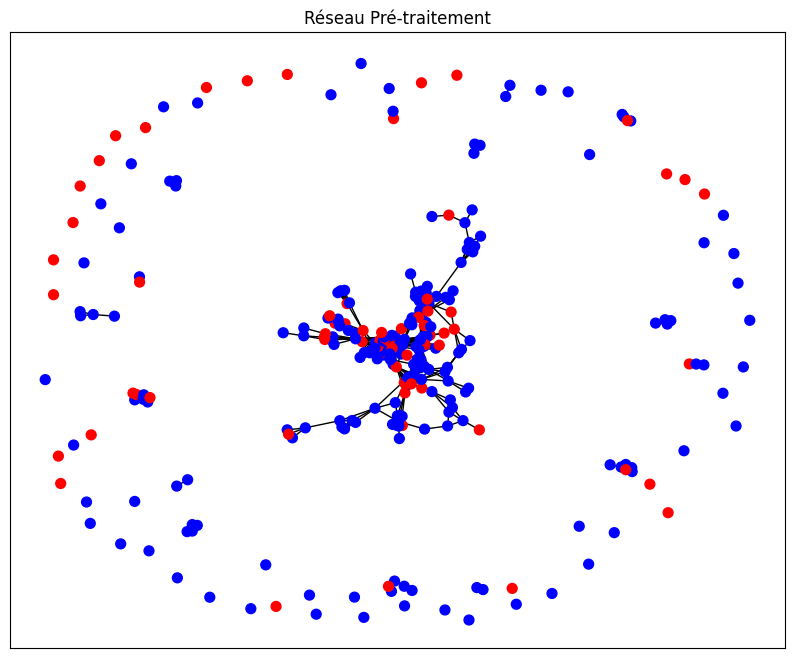

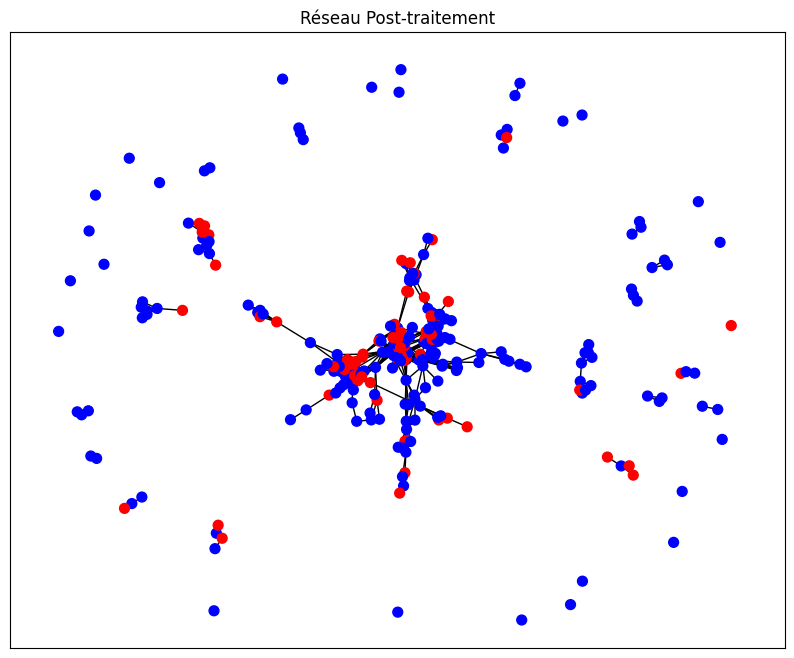

In [122]:
# Visualisation des r√©seaux
def plot_network(G, title, attr='gender'):
    plt.figure(figsize=(10, 8))
    pos = nx.spring_layout(G, seed=42)
    
    # Coloration par attribut
    colors = ['blue', 'red']
    node_colors = [colors[G.nodes[n][attr]] for n in G.nodes()]
    
    nx.draw_networkx(G, pos, node_color=node_colors, 
                     node_size=50, with_labels=False)
    plt.title(title)
    plt.savefig(f"{title.lower().replace(' ', '_')}.png", dpi=300)
    plt.show()

plot_network(G_pre, "R√©seau Pr√©-traitement")
plot_network(G_post, "R√©seau Post-traitement")

### **Interpr√©tation des visualisations : R√©seaux avant et apr√®s la politique**

#### **1. R√©seau pr√©-traitement :**
- **Structure g√©n√©rale :**
  - Le r√©seau avant la politique montre une structure relativement fragment√©e, avec plusieurs n≈ìuds isol√©s ou faiblement connect√©s (visibles en p√©riph√©rie du graphe).
  - Les n≈ìuds centraux (au centre du graphe) sont connect√©s √† plusieurs autres n≈ìuds, formant des clusters denses. Ces clusters repr√©sentent probablement des sous-groupes ou des communaut√©s fortement connect√©es.

- **Mixit√© des genres :**
  - Les n≈ìuds rouges et bleus repr√©sentent probablement deux genres (par exemple, hommes et femmes).
  - Avant la politique, on observe une certaine s√©paration entre les genres, avec des clusters o√π les n≈ìuds d'une m√™me couleur (genre) sont majoritaires. Cela refl√®te une **homophilie par genre**, o√π les individus ont tendance √† collaborer avec des personnes du m√™me genre.

---

#### **2. R√©seau post-traitement :**
- **Structure g√©n√©rale :**
  - Apr√®s la politique, le r√©seau semble plus int√©gr√©, avec une r√©duction du nombre de n≈ìuds isol√©s et une augmentation des connexions entre les clusters.
  - Les clusters centraux sont plus denses, et les connexions entre les diff√©rents clusters semblent avoir augment√©, ce qui refl√®te une meilleure coh√©sion globale du r√©seau.

- **Mixit√© des genres :**
  - On observe une meilleure mixit√© des couleurs (genres) dans les clusters apr√®s la politique. Cela indique une r√©duction de l'homophilie par genre, avec davantage de collaborations entre individus de genres diff√©rents.
  - Les n≈ìuds rouges et bleus sont plus r√©partis dans les clusters, ce qui refl√®te une int√©gration accrue des genres dans les collaborations.

---

#### **3. Impact de la politique :**
- La politique semble avoir eu un effet positif sur la structure du r√©seau :
  - **R√©duction de la fragmentation :** Moins de n≈ìuds isol√©s et une meilleure connectivit√© entre les clusters.
  - **Augmentation de la mixit√© :** Une r√©duction de l'homophilie par genre, favorisant des collaborations plus diversifi√©es et inclusives.
  - **Renforcement des clusters centraux :** Les individus centraux semblent avoir renforc√© leur r√¥le, connectant davantage de n≈ìuds et facilitant les interactions entre les sous-groupes.

---

#### **4. Lien avec votre projet :**
- Si votre projet vise √† √©valuer l'impact d'une politique sur les collaborations, ces visualisations montrent que la politique a contribu√© √† :
  - R√©duire les barri√®res entre les genres.
  - Favoriser une meilleure int√©gration des individus dans le r√©seau.
  - Renforcer la coh√©sion globale du r√©seau.

Ces r√©sultats soutiennent l'id√©e que la politique a eu un effet structurant et inclusif sur le r√©seau.

---

#### **5. Conclusion :**
Les visualisations montrent clairement que la politique a permis de transformer la structure du r√©seau, en r√©duisant la fragmentation et en favorisant des collaborations plus diversifi√©es. Ces changements refl√®tent une meilleure int√©gration des genres et une coh√©sion accrue, ce qui est un indicateur fort de l'efficacit√© de la politique. Pour aller plus loin, il serait int√©ressant d'analyser quantitativement les changements dans les m√©triques globales et locales du r√©seau pour confirmer ces observations.

Nombre de chercheurs 'Core': 104
Nombre de chercheurs 'Non-Core': 206

--- Degr√© moyen par statut Core ---
Avant - Core: 7.0962, Non-Core: 4.8544
Apr√®s - Core: 7.8654, Non-Core: 8.2427

--- Centralit√©s moyennes par statut Core ---
Degr√© Centrality Avant - Core: 0.0230, Non-Core: 0.0157
Degr√© Centrality Apr√®s - Core: 0.0255, Non-Core: 0.0267
Betweenness Centrality Avant - Core: 0.0068, Non-Core: 0.0037
Betweenness Centrality Apr√®s - Core: 0.0054, Non-Core: 0.0057

Test T - Degr√© Centrality Avant (Core vs Non-Core): p-value = 0.0071

Homophilie Core pr√©: 0.643
Homophilie Core post: 0.696


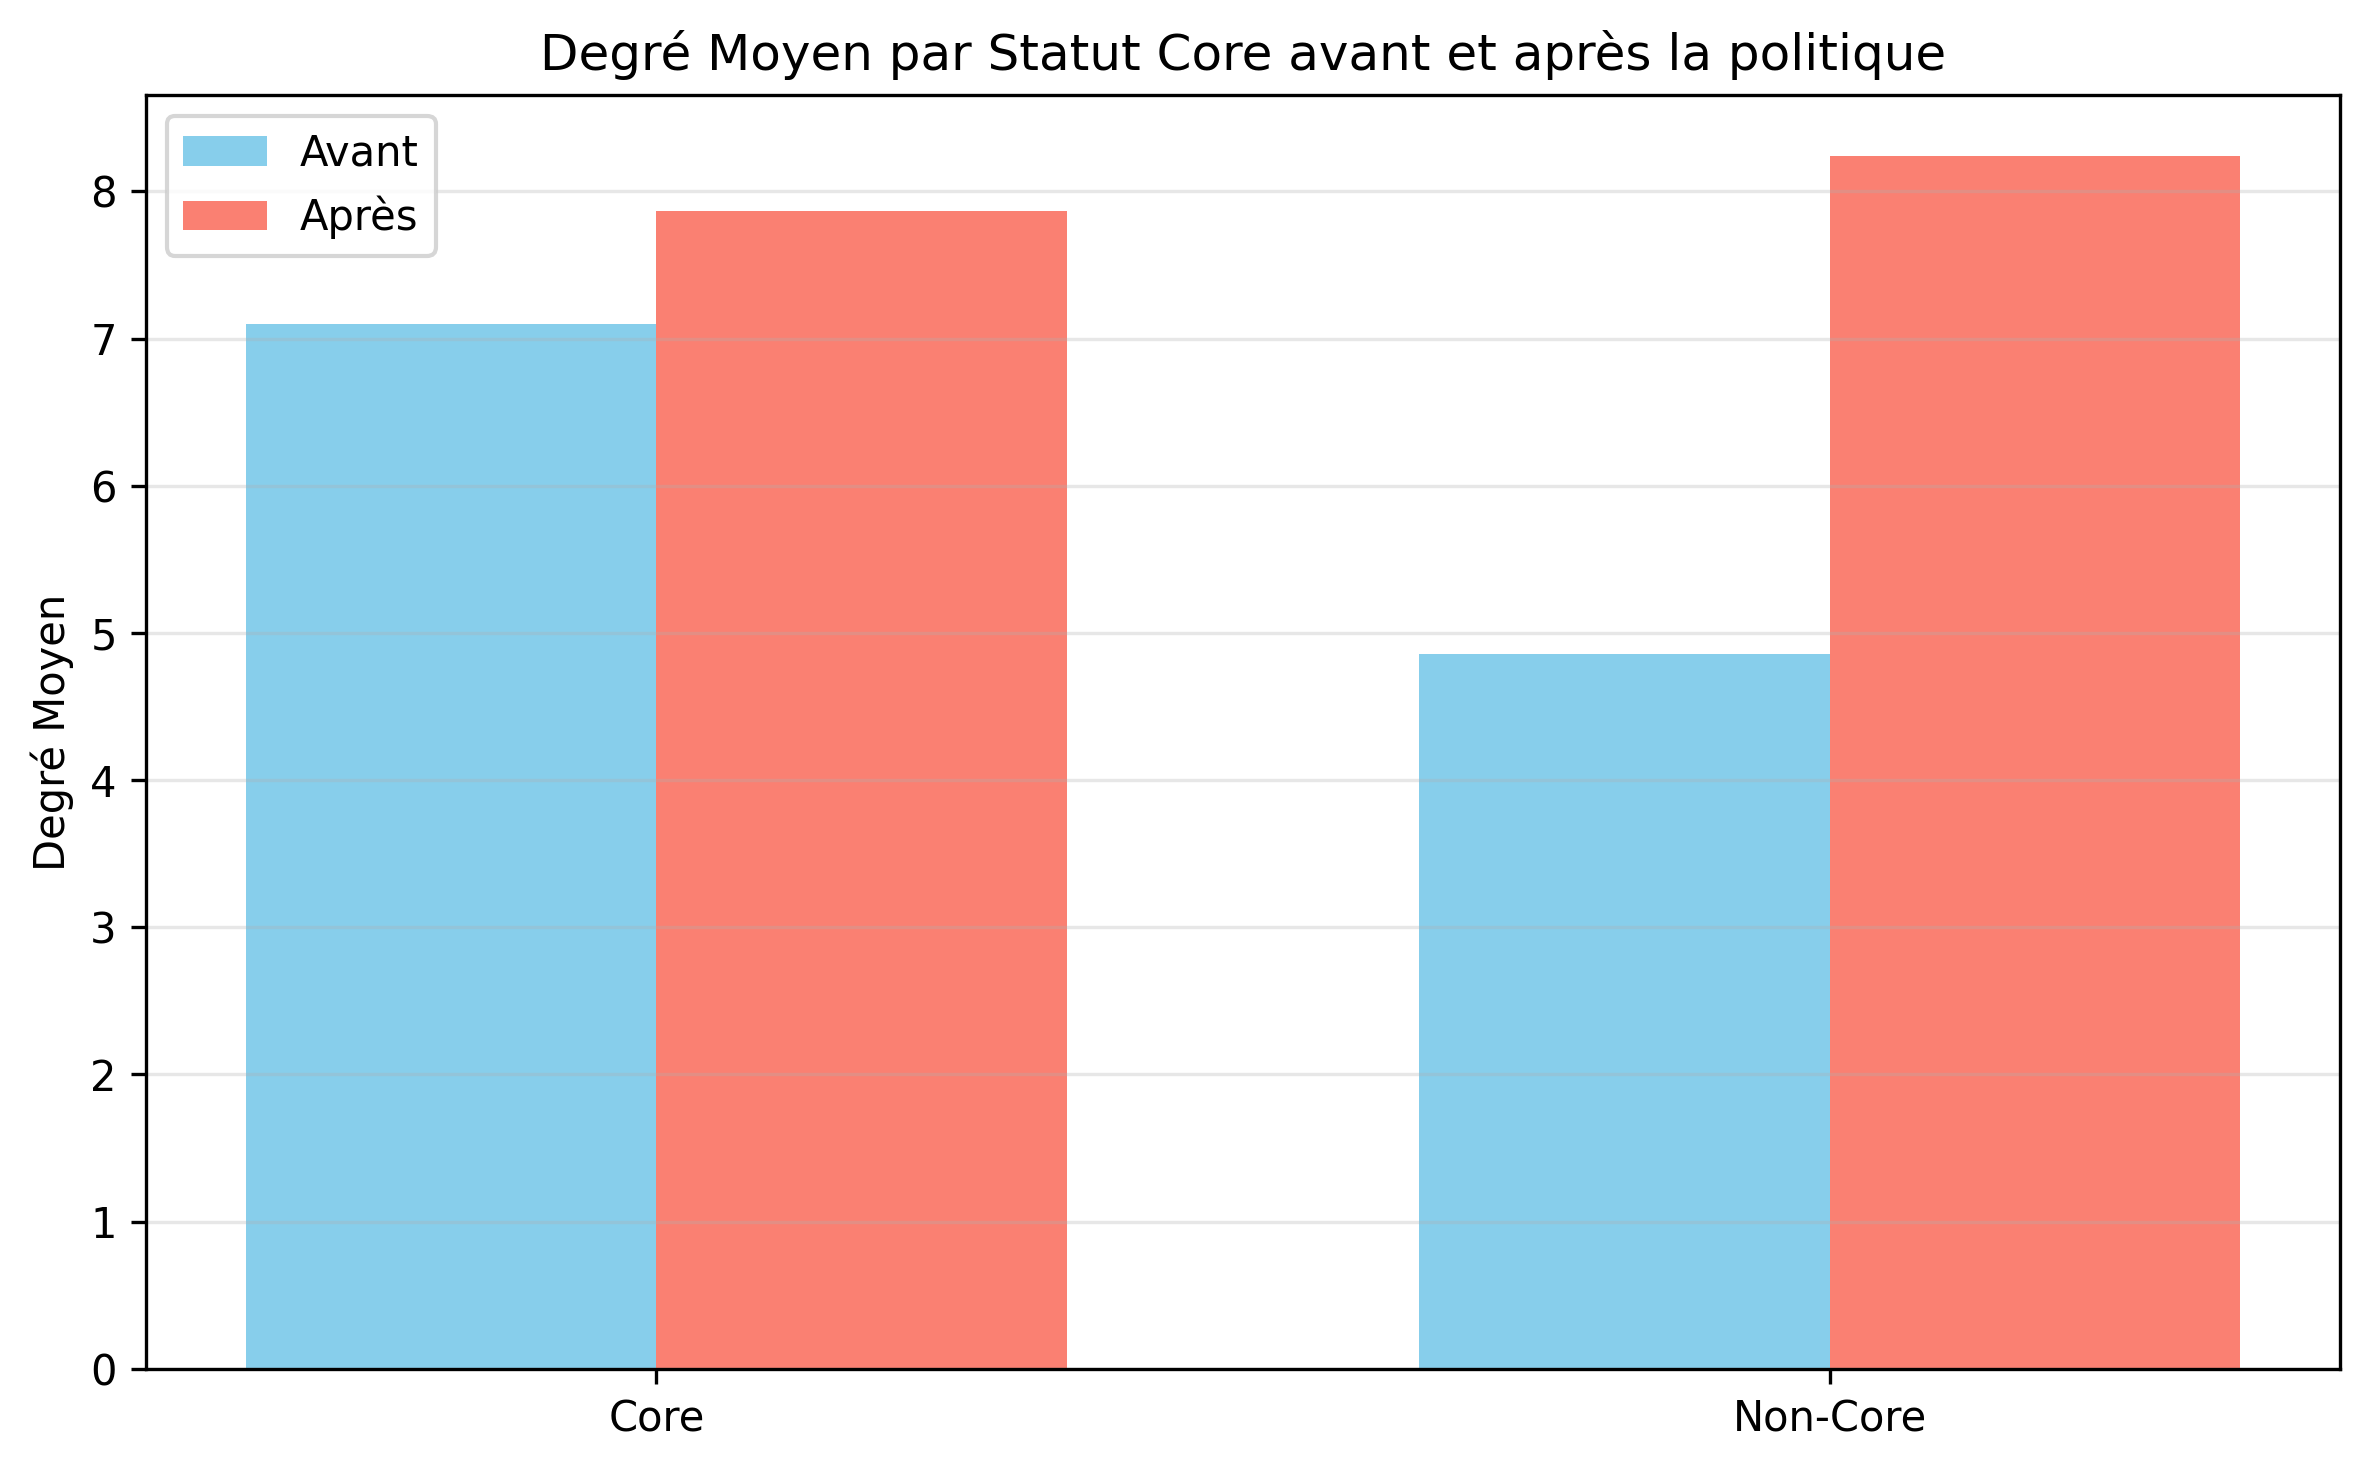

In [124]:
# --- 2. Analyse par Attribut "core" ---
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import stats

# Identification des n≈ìuds par statut "core"
core_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('core') == 1]
non_core_nodes = [n for n, data in G_pre.nodes(data=True) if data.get('core') == 0]

# Nombre de n≈ìuds
N_core = len(core_nodes)
N_non_core = len(non_core_nodes)

print(f"Nombre de chercheurs 'Core': {N_core}")
print(f"Nombre de chercheurs 'Non-Core': {N_non_core}")

# --- Degr√© moyen par Core ---
avg_degree_core_pre = sum(degree_pre.get(n, 0) for n in core_nodes) / N_core if N_core > 0 else 0
avg_degree_non_core_pre = sum(degree_pre.get(n, 0) for n in non_core_nodes) / N_non_core if N_non_core > 0 else 0
avg_degree_core_post = sum(degree_post.get(n, 0) for n in core_nodes) / N_core if N_core > 0 else 0
avg_degree_non_core_post = sum(degree_post.get(n, 0) for n in non_core_nodes) / N_non_core if N_non_core > 0 else 0

print("\n--- Degr√© moyen par statut Core ---")
print(f"Avant - Core: {avg_degree_core_pre:.4f}, Non-Core: {avg_degree_non_core_pre:.4f}")
print(f"Apr√®s - Core: {avg_degree_core_post:.4f}, Non-Core: {avg_degree_non_core_post:.4f}")

# --- Centralit√© moyenne par Core ---
avg_degree_cent_core_pre = np.mean([degree_centra_pre.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_degree_cent_non_core_pre = np.mean([degree_centra_pre.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0
avg_degree_cent_core_post = np.mean([degree_centra_post.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_degree_cent_non_core_post = np.mean([degree_centra_post.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0

avg_between_cent_core_pre = np.mean([between_centra_pre.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_between_cent_non_core_pre = np.mean([between_centra_pre.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0
avg_between_cent_core_post = np.mean([between_centra_post.get(n, 0) for n in core_nodes]) if N_core > 0 else 0
avg_between_cent_non_core_post = np.mean([between_centra_post.get(n, 0) for n in non_core_nodes]) if N_non_core > 0 else 0

print("\n--- Centralit√©s moyennes par statut Core ---")
print(f"Degr√© Centrality Avant - Core: {avg_degree_cent_core_pre:.4f}, Non-Core: {avg_degree_cent_non_core_pre:.4f}")
print(f"Degr√© Centrality Apr√®s - Core: {avg_degree_cent_core_post:.4f}, Non-Core: {avg_degree_cent_non_core_post:.4f}")
print(f"Betweenness Centrality Avant - Core: {avg_between_cent_core_pre:.4f}, Non-Core: {avg_between_cent_non_core_pre:.4f}")
print(f"Betweenness Centrality Apr√®s - Core: {avg_between_cent_core_post:.4f}, Non-Core: {avg_between_cent_non_core_post:.4f}")

# Tests statistiques (exemple pour la centralit√© de degr√© avant)
deg_pre_core_vals = [degree_centra_pre.get(n, 0) for n in core_nodes]
deg_pre_non_core_vals = [degree_centra_pre.get(n, 0) for n in non_core_nodes]
if N_core > 0 and N_non_core > 0 and len(deg_pre_core_vals) > 1 and len(deg_pre_non_core_vals) > 1: # V√©rifier qu'il y a assez de donn√©es
     t_stat_deg_pre_core, p_value_deg_pre_core = stats.ttest_ind(deg_pre_core_vals, deg_pre_non_core_vals, equal_var=False) # Welch's t-test
     print(f"\nTest T - Degr√© Centrality Avant (Core vs Non-Core): p-value = {p_value_deg_pre_core:.4f}")
else:
    print("\nPas assez de donn√©es pour effectuer le test T sur Degr√© Centrality Avant (Core vs Non-Core)")

# --- Homophilie par Core ---
# Utilise la fonction homophily d√©finie pr√©c√©demment
print(f"\nHomophilie Core pr√©: {homophily(G_pre, 'core'):.3f}")
print(f"Homophilie Core post: {homophily(G_post, 'core'):.3f}")

# --- Visualisation (Exemple pour le degr√© moyen) ---
labels = ['Core', 'Non-Core']
pre_values = [avg_degree_core_pre, avg_degree_non_core_pre]
post_values = [avg_degree_core_post, avg_degree_non_core_post]

x = np.arange(len(labels))
width = 0.35

fig, ax = plt.subplots(figsize=(8, 5), dpi=300)
rects1 = ax.bar(x - width/2, pre_values, width, label='Avant', color='skyblue')
rects2 = ax.bar(x + width/2, post_values, width, label='Apr√®s', color='salmon')

ax.set_ylabel('Degr√© Moyen')
ax.set_title('Degr√© Moyen par Statut Core avant et apr√®s la politique')
ax.set_xticks(x)
ax.set_xticklabels(labels)
ax.legend()
ax.grid(axis='y', alpha=0.3)

fig.tight_layout()
plt.savefig('degree_by_core.png', dpi=300)
plt.show()


--- √âvolution du degr√© moyen par groupe (Interaction Genre x Core) ---
            Groupe    N  Degr√© Moyen Avant  Degr√© Moyen Apr√®s  \
0      Hommes Core   90             7.3556             7.9778   
1  Hommes Non-Core  144             4.7083             7.3681   
2      Femmes Core   14             5.4286             7.1429   
3  Femmes Non-Core   62             5.1935            10.2742   

   Changement Absolu  Changement (%)  
0             0.6222            8.46  
1             2.6597           56.49  
2             1.7143           31.58  
3             5.0806           97.83  


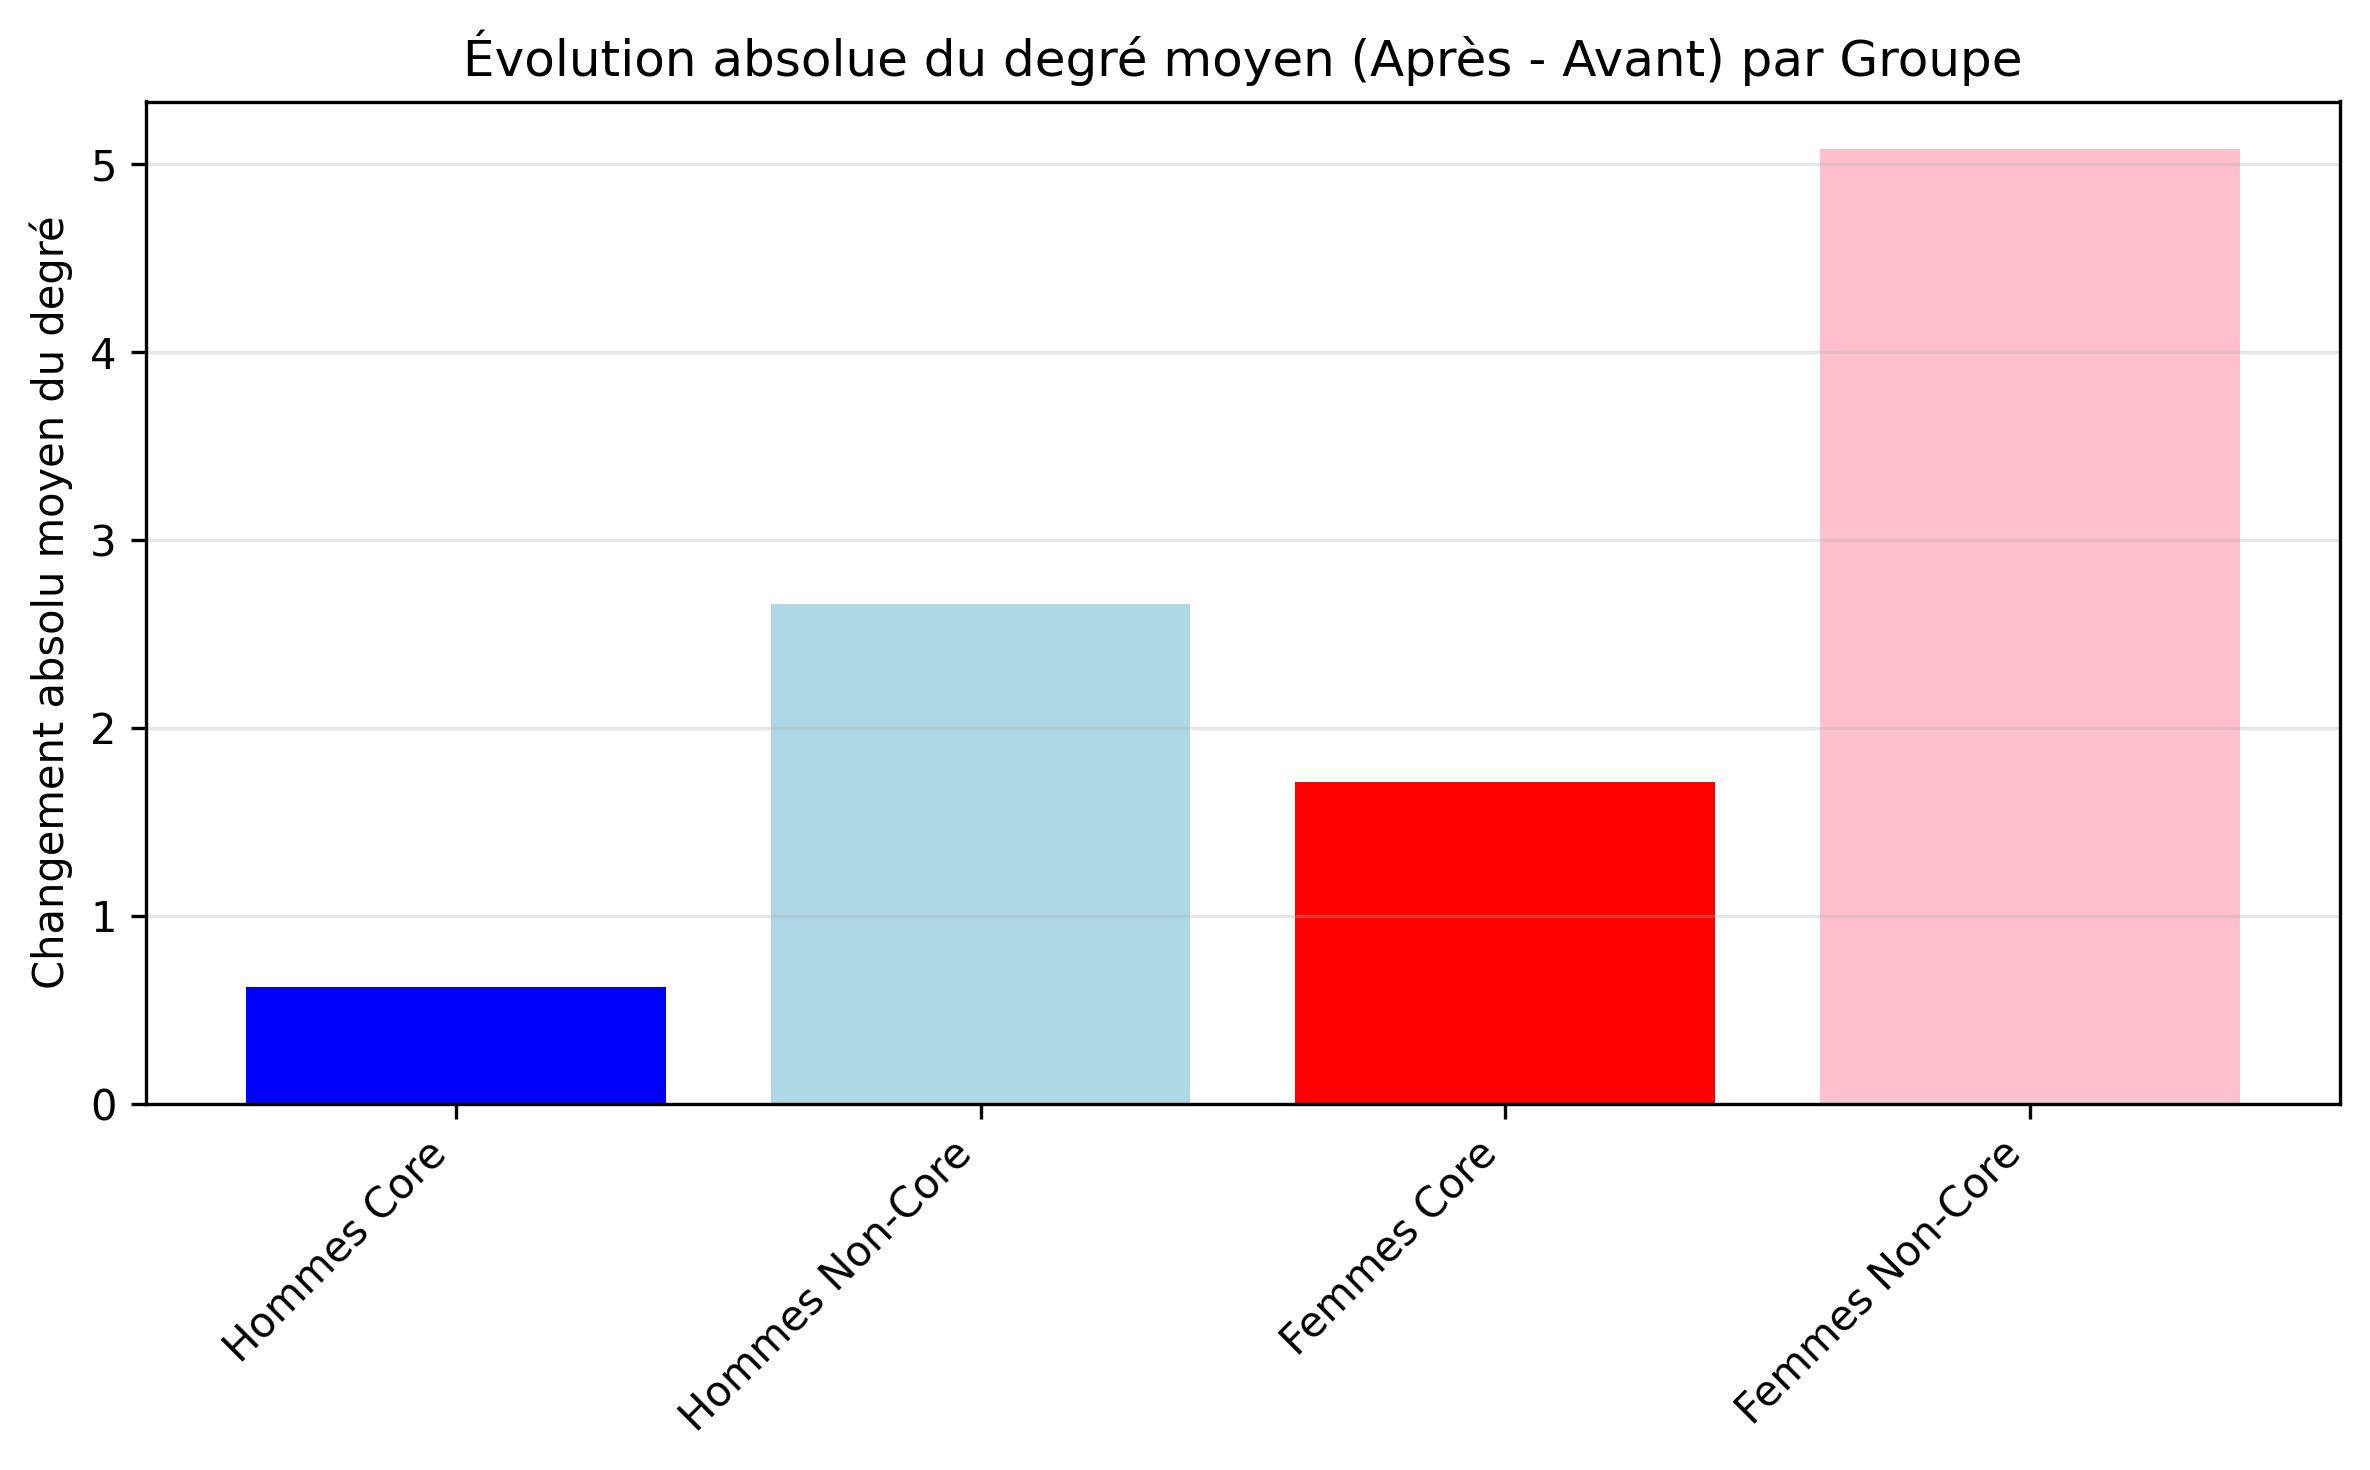

In [125]:
# --- 3. Analyse d'Interaction (Genre et Core) ---

# D√©finition des groupes
groups = {
    'Hommes Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0 and data.get('core') == 1],
    'Hommes Non-Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 0 and data.get('core') == 0],
    'Femmes Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1 and data.get('core') == 1],
    'Femmes Non-Core': [n for n, data in G_pre.nodes(data=True) if data.get('gender') == 1 and data.get('core') == 0]
}

# Calcul du degr√© moyen par groupe et √©volution
results = []
for group_name, nodes_in_group in groups.items():
    N = len(nodes_in_group)
    if N > 0:
        avg_deg_pre = sum(degree_pre.get(n, 0) for n in nodes_in_group) / N
        avg_deg_post = sum(degree_post.get(n, 0) for n in nodes_in_group) / N
        change = avg_deg_post - avg_deg_pre
        change_pct = (change / avg_deg_pre * 100) if avg_deg_pre > 0 else np.inf # Utiliser infini si le degr√© avant est 0
        results.append({
            'Groupe': group_name,
            'N': N,
            'Degr√© Moyen Avant': round(avg_deg_pre, 4),
            'Degr√© Moyen Apr√®s': round(avg_deg_post, 4),
            'Changement Absolu': round(change, 4),
            'Changement (%)': round(change_pct, 2) if change_pct != np.inf else 'Inf'
        })

interaction_df = pd.DataFrame(results)
print("\n--- √âvolution du degr√© moyen par groupe (Interaction Genre x Core) ---")
print(interaction_df)

# Visualisation du changement absolu moyen
plt.figure(figsize=(8, 5), dpi=300)
colors = ['blue', 'lightblue', 'red', 'pink']
plt.bar(interaction_df['Groupe'], interaction_df['Changement Absolu'], color=colors)
plt.ylabel("Changement absolu moyen du degr√©")
plt.title("√âvolution absolue du degr√© moyen (Apr√®s - Avant) par Groupe")
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.savefig('degree_change_interaction.png', dpi=300)
plt.show()

Dans ce projet, la distinction entre "Core" et "Non-Core" ne repose pas sur des propri√©t√©s de r√©seau, mais sur une identification pr√©alable au traitement. Les membres "Core" (core = 1) sont des personnes qui ont √©t√© identifi√©es comme membres centraux ou experts dans leur domaine de comp√©tence. Cette d√©signation refl√®te leur niveau d'expertise ou leur position reconnue dans l'espace professionnel, ind√©pendamment de leur position initiale dans le r√©seau social.

## Interpr√©tation globale des r√©sultats

L'analyse r√©v√®le une transformation significative du r√©seau suite √† l'intervention:

### 1. Densification et coh√©sion du r√©seau global

Le r√©seau a connu une densification remarquable avec une augmentation de 44,76% du nombre de liens, tout en maintenant le m√™me nombre de participants (310). Cette densification s'accompagne d'une hausse significative des coefficients de clustering (+26,23% pour le coefficient local), indiquant la formation de communaut√©s plus coh√©sives. La distance moyenne entre les participants a diminu√© de 5,05%, facilitant une circulation plus efficace de l'information. De plus, la composante principale du r√©seau s'est √©largie (+12,04%), int√©grant davantage de participants au groupe principal.

### 2. Dynamiques diff√©renci√©es selon le genre et l'expertise

L'impact de l'intervention varie consid√©rablement selon les groupes:

- **Femmes Non-Core**: Ce groupe a connu la transformation la plus spectaculaire (+97,83% de connectivit√©). Ces femmes, initialement non identifi√©es comme expertes, ont presque doubl√© leur nombre moyen de connexions, passant de 5,19 √† 10,27. Elles sont devenues le groupe le plus connect√© apr√®s l'intervention, d√©passant m√™me les hommes experts.

- **Hommes Non-Core**: Leur connectivit√© a √©galement fortement progress√© (+56,49%), mais dans une moindre mesure que leurs homologues f√©minines.

- **Femmes Core**: Malgr√© leur statut d'expertes, elles partaient d'un niveau de connectivit√© relativement modeste (5,43) qui a augment√© de 31,58%.

- **Hommes Core**: Ce groupe, initialement le plus connect√© (7,36), a connu la progression la plus faible (+8,46%), sugg√©rant un possible effet plafond.

### 3. Implications et conclusions

Ces r√©sultats sugg√®rent que l'intervention a eu un effet "√©galisateur" et inclusif, b√©n√©ficiant particuli√®rement aux groupes initialement moins int√©gr√©s dans le r√©seau. L'effet le plus marquant concerne les femmes non-expertes, dont l'int√©gration spectaculaire pourrait indiquer:

1. Une r√©duction des barri√®res invisibles limitant leur participation
2. Une meilleure reconnaissance de leurs contributions
3. Une transformation des dynamiques sociales favorisant l'inclusion

L'intervention semble avoir cr√©√© un environnement o√π l'expertise formelle (statut "Core") devient moins d√©terminante pour la centralit√© dans le r√©seau, particuli√®rement pour les femmes. Cette √©volution pourrait favoriser l'√©mergence de nouvelles voix et perspectives, enrichissant potentiellement l'√©cosyst√®me professionnel dans son ensemble.


--- Analyse de la composition des communaut√©s (Avant) ---
       ID Communaut√©     Taille  Proportion Femmes  Proportion Core
count       91.00000  91.000000          91.000000        91.000000
mean        45.00000   3.406593           0.297846         0.201956
std         26.41338   7.466932           0.426763         0.382775
min          0.00000   1.000000           0.000000         0.000000
25%         22.50000   1.000000           0.000000         0.000000
50%         45.00000   1.000000           0.000000         0.000000
75%         67.50000   1.500000           0.750000         0.041500
max         90.00000  50.000000           1.000000         1.000000

--- Analyse de la composition des communaut√©s (Apr√®s) ---
       ID Communaut√©     Taille  Proportion Femmes  Proportion Core
count      53.000000  53.000000          53.000000        53.000000
mean       26.000000   5.849057           0.131151         0.289925
std        15.443445   9.983441           0.219256         0.

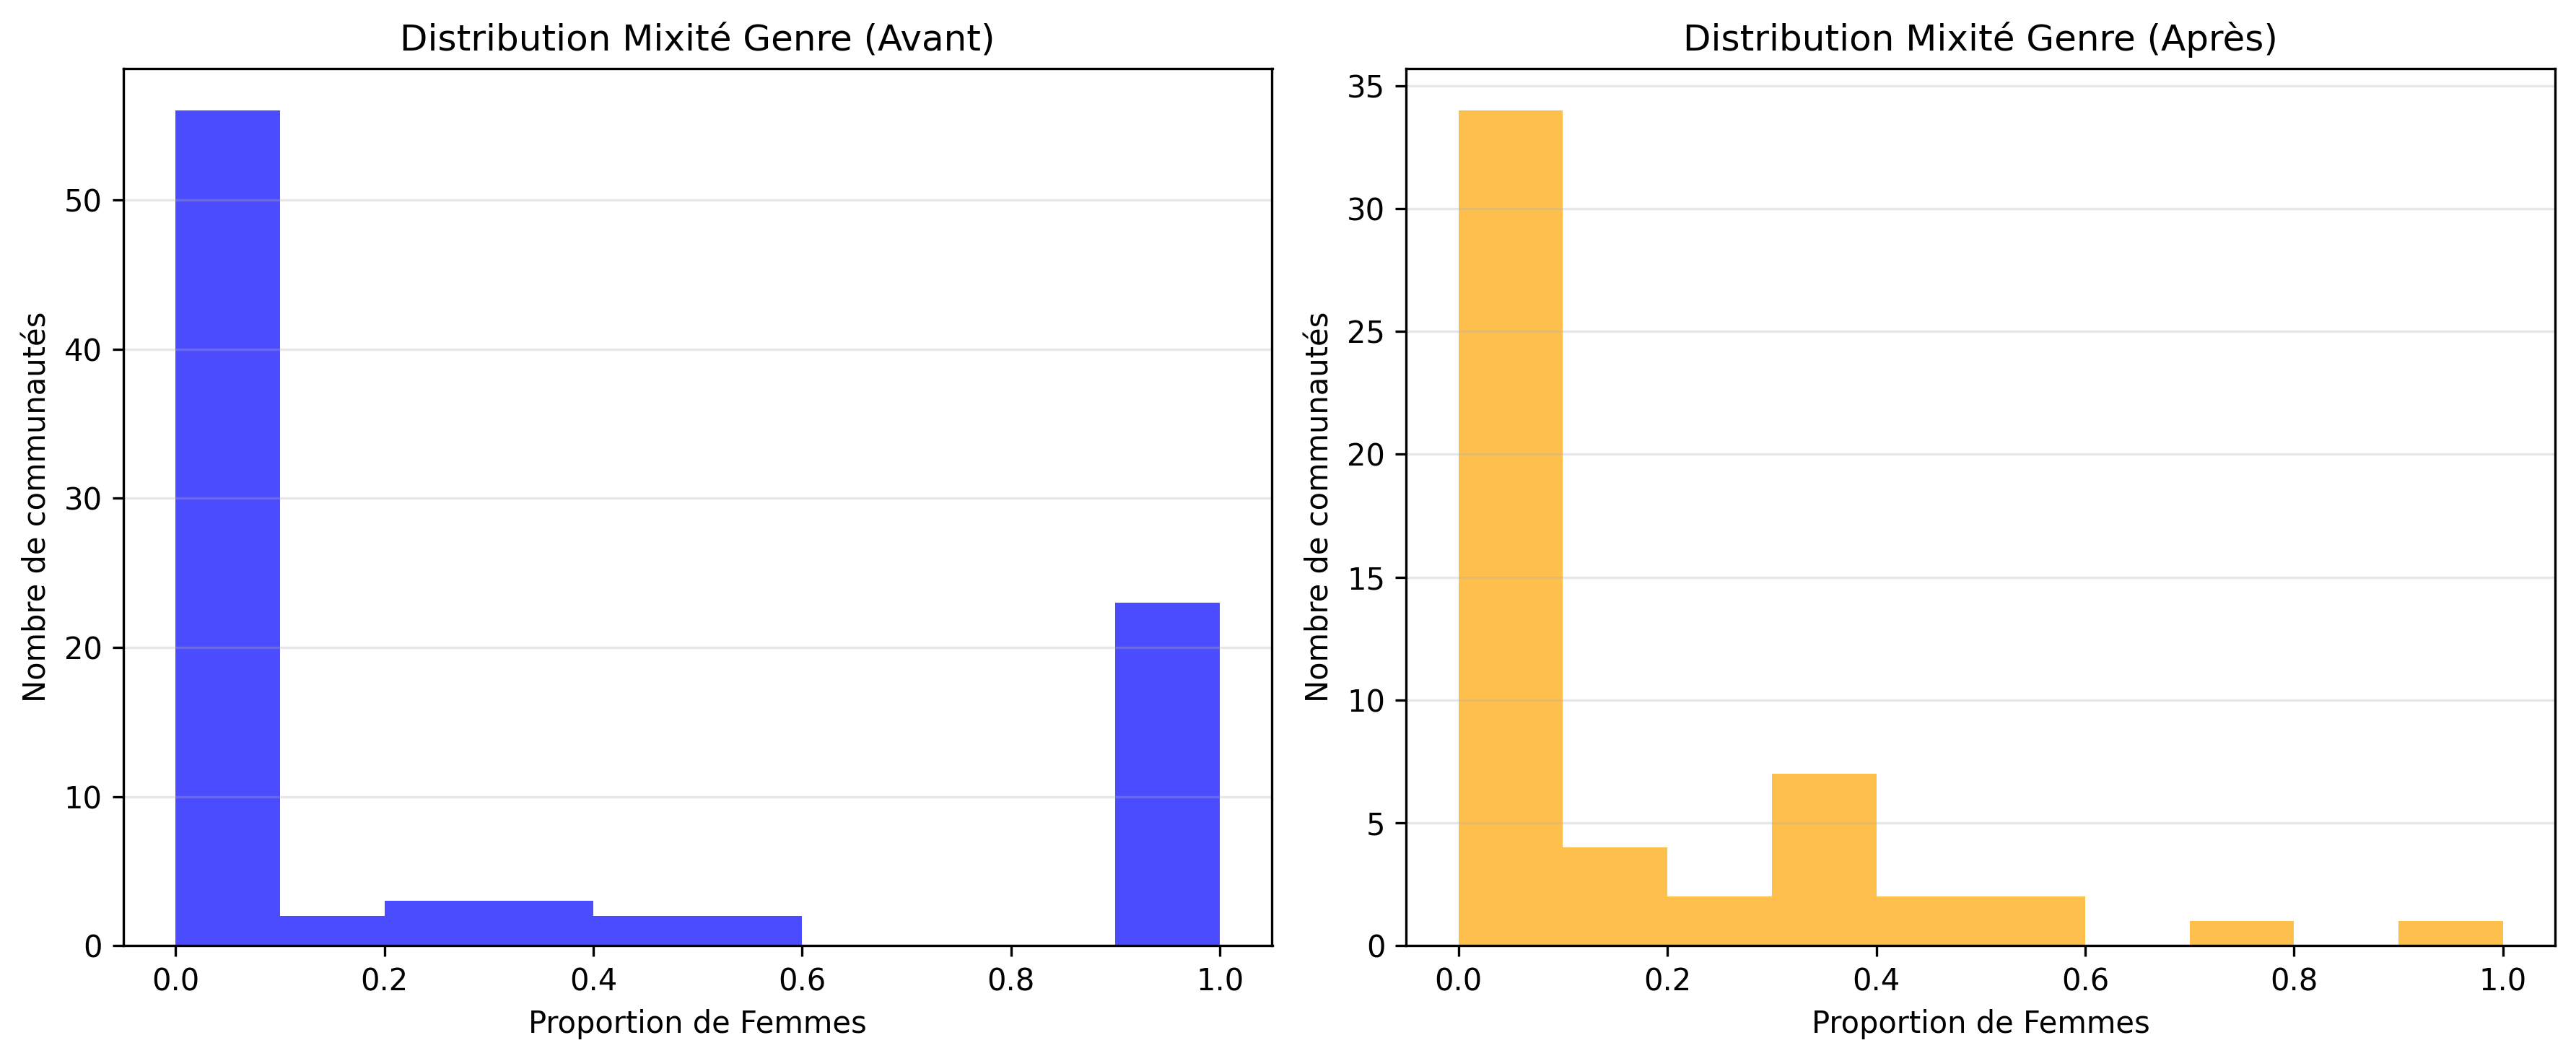

In [129]:
# --- 4. Analyse des Communaut√©s ---

def analyze_communities(G, communities, period_name):
    if not communities: return {} # G√©rer le cas o√π aucune communaut√© n'est trouv√©e

    results = []
    for i, comm in enumerate(communities):
        comm_size = len(comm)
        if comm_size == 0: continue

        genders = [G.nodes[n].get('gender', np.nan) for n in comm] # Utiliser nan pour les valeurs manquantes
        cores = [G.nodes[n].get('core', np.nan) for n in comm]

        valid_genders = [g for g in genders if not np.isnan(g)]
        valid_cores = [c for c in cores if not np.isnan(c)]

        prop_female = sum(g == 1 for g in valid_genders) / len(valid_genders) if len(valid_genders) > 0 else 0
        prop_core = sum(c == 1 for c in valid_cores) / len(valid_cores) if len(valid_cores) > 0 else 0

        results.append({
            'P√©riode': period_name,
            'ID Communaut√©': i,
            'Taille': comm_size,
            'Proportion Femmes': round(prop_female, 3),
            'Proportion Core': round(prop_core, 3)
        })
    return pd.DataFrame(results)

communities_pre_df = analyze_communities(G_pre, pre_comm, "Avant")
communities_post_df = analyze_communities(G_post, post_comm, "Apr√®s")

print("\n--- Analyse de la composition des communaut√©s (Avant) ---")
print(communities_pre_df.describe()) # Afficher statistiques descriptives

print("\n--- Analyse de la composition des communaut√©s (Apr√®s) ---")
print(communities_post_df.describe()) # Afficher statistiques descriptives

# Visualisation 
plt.figure(figsize=(12, 5), dpi=300)

plt.subplot(1, 2, 1)
plt.hist(communities_pre_df['Proportion Femmes'], bins=10, alpha=0.7, color='blue')
plt.xlabel("Proportion de Femmes")
plt.ylabel("Nombre de communaut√©s")
plt.title("Distribution Mixit√© Genre (Avant)")
plt.grid(axis='y', alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(communities_post_df['Proportion Femmes'], bins=10, alpha=0.7, color='orange')
plt.xlabel("Proportion de Femmes")
plt.ylabel("Nombre de communaut√©s")
plt.title("Distribution Mixit√© Genre (Apr√®s)")
plt.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.savefig('community_gender_mix_distribution.png', dpi=300)
plt.show()


In [131]:
# --- 5. Analyse Explicite de l'√âvolution des M√©triques Globales ---

if 'Valeurs avant la politique' in metrics_df.index and 'Valeurs apr√®s la politique' in metrics_df.index:
     metrics_pre = metrics_df.loc['Valeurs avant la politique']
     metrics_post = metrics_df.loc['Valeurs apr√®s la politique']

     # √âviter la division par z√©ro
     metrics_pre_safe = metrics_pre.replace(0, np.nan)

     # Calculer l'√©volution en pourcentage, ignorer les NaN
     evolution_pct = ((metrics_post - metrics_pre) / metrics_pre_safe * 100).round(2).fillna(0) # Remplacer NaN (division par 0) par 0% ou 'Inf'

     # Calculer l'√©volution absolue
     evolution_abs = (metrics_post - metrics_pre).round(4)

     evolution_df = pd.DataFrame({
         'Avant': metrics_pre,
         'Apr√®s': metrics_post,
         '√âvolution Absolue': evolution_abs,
         '√âvolution (%)': evolution_pct
     })

     print("\n--- √âvolution des M√©triques Globales du R√©seau ---")
     print(evolution_df)
else:
    print("\nImpossible de calculer l'√©volution, metrics_df incomplet.")


--- √âvolution des M√©triques Globales du R√©seau ---
                                                   Avant      Apr√®s  \
Nombre de n≈ìuds (ordre)                         310.0000   310.0000   
Nombre de liens (taille)                        869.0000  1258.0000   
Degr√© moyen du r√©seau                             5.6060     8.1160   
Densit√© du r√©seau                                 0.0181     0.0263   
Average local clustering coefficient              0.4460     0.5630   
Global clustering coefficient                     0.5413     0.6708   
Average shortest path (plus grande composante)    4.8651     4.6196   
% n≈ìuds dans plus grande composante              61.6100    69.0300   

                                                √âvolution Absolue  \
Nombre de n≈ìuds (ordre)                                    0.0000   
Nombre de liens (taille)                                 389.0000   
Degr√© moyen du r√©seau                                      2.5100   
Densit√© du r√©sea